In [1]:
!pip install -r requirements.txt

In [2]:
# Libraries import

import sys
import io
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pysindy as ps
from pysindy.optimizers import STLSQ
from pysindy import SINDy

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Optimizer libraries

from pysindy.optimizers import SR3              #optimizer = SR3(threshold=0.1, nu=1e-2)
from sklearn.linear_model import Lasso          #optimizer = Lasso(alpha=0.1)
from sklearn.linear_model import ElasticNet     #optimizer = ElasticNet(alpha=0.1, l1_ratio=0.5)
from pysindy.optimizers import FROLS            #optimizer = FROLS()
from pysindy.optimizers import STLSQ            #optimizer = STLSQ(threshold=0.01, alpha=1e-5)  alpha is the L2 regularization parameter
from pysindy.optimizers import ConstrainedSR3
#from pysindy.optimizers import MIOSR
from pysindy.optimizers import SR3
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import Akima1DInterpolator
from scipy.ndimage import gaussian_filter, gaussian_filter1d

**Load the data below by running the cell for UNNORMALIZED RESULTS (NOT USED BY PINN)**

In [21]:
# Load the parameters data
params_df = pd.read_csv('Parameters/channel_parameters.csv')

# Load the couette parameters data
couette_params_df = pd.read_csv('Parameters/couette_parameters.csv')

# Load channel Augmented results data
channel_int_augmented_datafilenames = {
    180: 'Unnormalized_interpolated_data\Channel_180_unnormalized.csv',
    550: 'Unnormalized_interpolated_data\Channel_550_unnormalized.csv',
    1000:'Unnormalized_interpolated_data\Channel_1000_unnormalized.csv',
    2000:'Unnormalized_interpolated_data\Channel_2000_unnormalized.csv',
    5200:'Unnormalized_interpolated_data\Channel_5200_unnormalized.csv'
}

# Load couette Augmented results data
couette_int_augmented_datafilenames = {
    9320:   'Unnormalized_interpolated_data\Couette_9320_unnormalized.csv',
    93100:  'Unnormalized_interpolated_data\Couette_93100_unnormalized.csv',
    22020:  'Unnormalized_interpolated_data\Couette_22020_unnormalized.csv',
    220100: 'Unnormalized_interpolated_data\Couette_220100_unnormalized.csv',
    50020:  'Unnormalized_interpolated_data\Couette_50020_unnormalized.csv',
    500100: 'Unnormalized_interpolated_data\Couette_500100_unnormalized.csv'
}

**Or Load the data below by running the cell for NORMALIZED RESULTS (USED BY PINN)**

In [6]:
# Load the parameters data
params_df = pd.read_csv('Parameters/channel_parameters.csv')

# Load the couette parameters data
couette_params_df = pd.read_csv('Parameters/couette_parameters.csv')

# Load channel Augmented results data
channel_int_augmented_datafilenames = {
    180: 'Normalized_interpolated_data\Channel_180_normalized.csv',
    550: 'Normalized_interpolated_data\Channel_550_normalized.csv',
    1000:'Normalized_interpolated_data\Channel_1000_normalized.csv',
    2000:'Normalized_interpolated_data\Channel_2000_normalized.csv',
    5200:'Normalized_interpolated_data\Channel_5200_normalized.csv'
}

# Load couette Augmented results data
couette_int_augmented_datafilenames = {
    9320:   'Normalized_interpolated_data\Couette_9320_normalized.csv',
    93100:  'Normalized_interpolated_data\Couette_93100_normalized.csv',
    22020:  'Normalized_interpolated_data\Couette_22020_normalized.csv',
    220100: 'Normalized_interpolated_data\Couette_220100_normalized.csv',
    50020:  'Normalized_interpolated_data\Couette_50020_normalized.csv',
    500100: 'Normalized_interpolated_data\Couette_500100_normalized.csv'
}

# Analysis  
We observe that we end up with the same shortcomings as the already existing RANS results. That is to say that the velocity gradients are so insignificant next to k that the results for u'u', v'v', and w'w' are all equivalent for a given test setup. Only u'v' is different from u'u', v'v', and w'w' because k is not involved in its computation.

# Monday 08/04 : Refined approach  

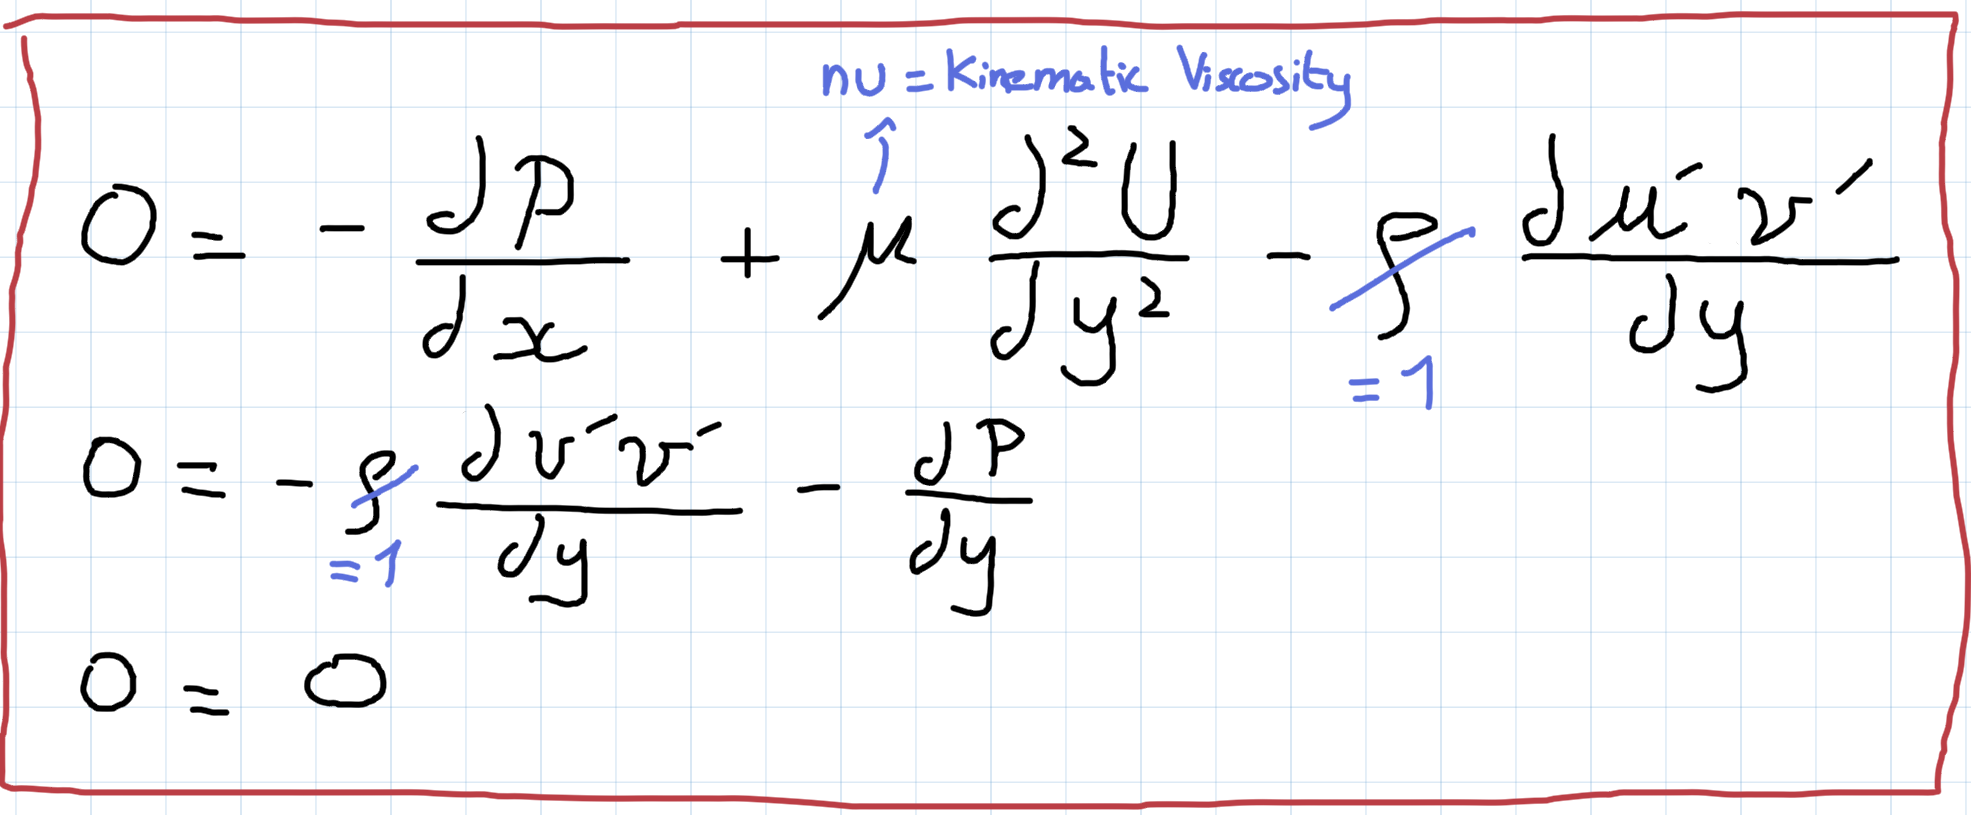  

0 = -dp/dx + nu d²U/dy² - d(u'v')/dy  
0 = -d(v'v')/dy - dp/dy  
0 = 0  

Reynolds Stress Transport equations

We should find those equations again. We are missing the pressure gradient.

**1. First, we observe that we lack dp/dx in the DNS data. We need to calculate it.**  
**2. Once we get dp/dx, we can start using PySINDy to get the ODEs.**  

***problem 1** : if we calculate dp/dx with 0 = -dp/dx + nu d²U/dy² - rau d(u'v')/dy, won't that bias our results and get us an ODE that looks exactly like the RANS equation ?*   
**Solution:** After meetings with PINN team, we are going to use the same calculation of dp/dx they have used to get coherent results : dp/dx = P/Lx  
**Update:** After meetings with CED team, we found out that the dp/dx calcultion used by the PINN team was wrong, however we have decided it is too late to do any changes. Results still stand as our governing equation use the same dp/dx  

***problem 2** : how to use sindy to get a second order differential equation?*  
**First approach : use the solution proposed by Tamas :**  
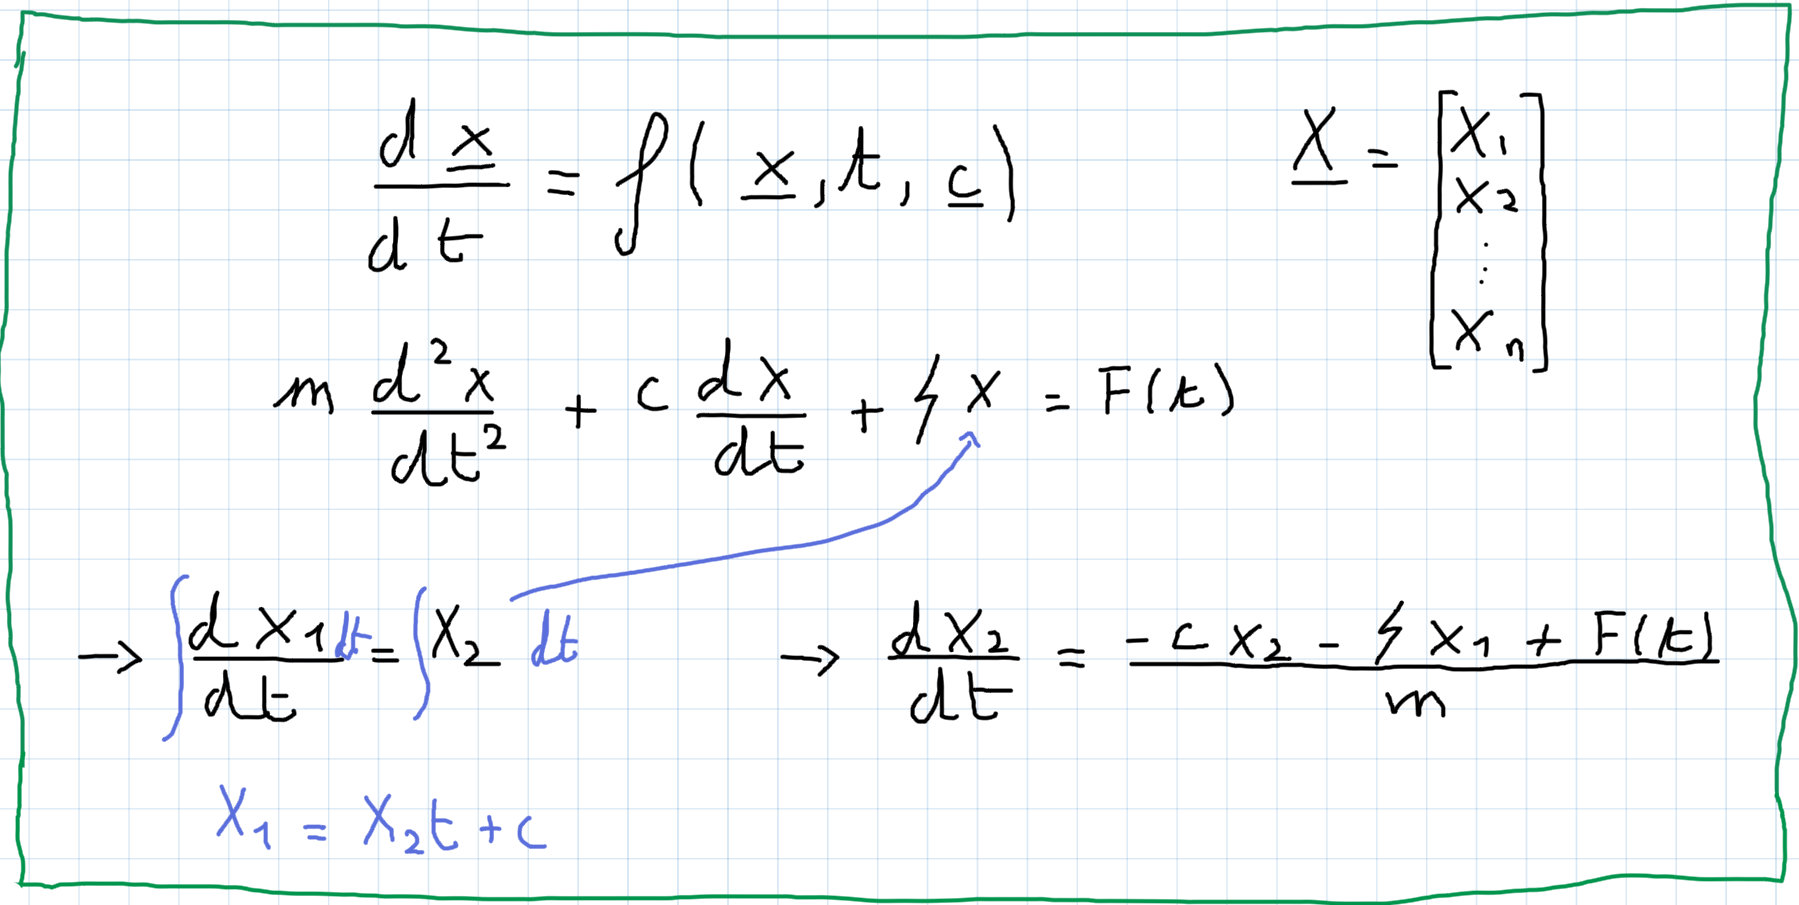  
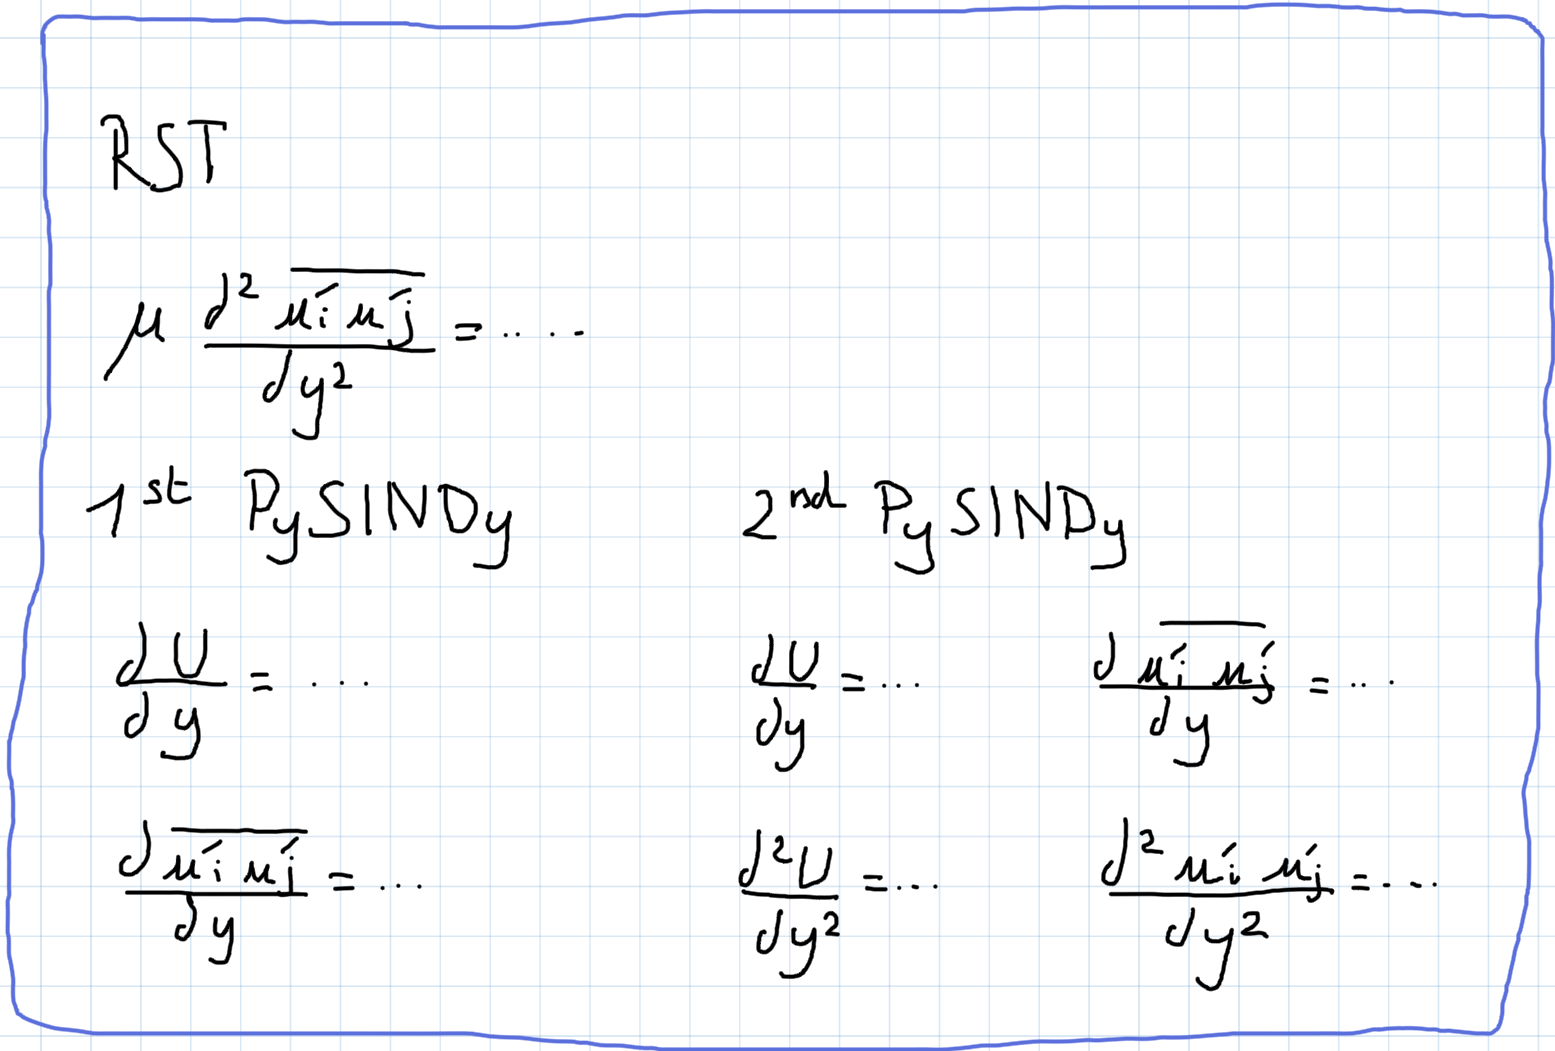  
**Second approach : use d²U/dy² directly as a target**  
We will start by using the second approach.


In [4]:
full_dataset = {
    "Channel": [180, 550, 1000, 2000, 5200],
    "Couette": [9320, 93100, 22020, 220100, 50020, 500100]
}

train_dataset = {
    "Channel": [180, 1000, 5200],
    "Couette": [220100]
}

test_dataset = {
    "Channel": [550, 2000],
    "Couette": [9320, 93100, 22020, 50020, 500100]
}

In [36]:
# Training the model for dvv/dy

selected_features = {
    #'U': True,
    #'dU/dy': True, 
    #'d2U/dy2': True,
    #'W': True,
    #'dW_dy': True,
    #'d2W/dy2': True,
    #'P': True,
    #'dP_dx': True,
    #'dP_dx_adam': True,
    'dP_dy': True,
    #'d2P/dy2': True,
    #'u\'u\'': True,
    #'duu_dy': True,
    #'d2uu/dy2': True,
    #'v\'v\'': True,
    #'dvv_dy': True,
    #'d2vv/dy2': True,
    #'w\'w\'': True,
    #'dww_dy': True,
    #'d2ww/dy2': True,
    #'u\'v\'': True,
    #'duv_dy': True,
    #'d2uv/dy2': True,
    'Re_tau': True, 
    #'nu': True, 
    #'u_tau': True
    #'inv_nu': True,
    #'inv_u_tau': True
}

target = 'dvv_dy'
rans_target = 'rans_dvv_dy'

# Set up variations of parameters
degrees = [1,2,3,4,5]
alphas = [0.1, 0.01]
max_iters = [1,2,3,4,5,6,7,8,9,10]

# Initialize lists to hold combined training features and targets
X_train_combined = []
X_dot_train_combined = []
X_test_combined = []
X_dot_test_combined = []

# Define a list to store models for comparison
models = []
performance_metrics = []    

# Dynamically build feature names list based on selected features
feature_names = [feature for feature in selected_features if selected_features[feature]]

# Function to construct features based on selected_features dictionary
def construct_features(int_data):
    features = np.hstack([int_data[[feature]].values for feature in selected_features if selected_features[feature]])
    return features

# Process each dataset for training and testing
for dataset_type, dataset in {'train': train_dataset, 'test': test_dataset}.items():
    for flow_type, ids in dataset.items():
        for id in ids:
            filename = channel_int_augmented_datafilenames[id] if flow_type == "Channel" else couette_int_augmented_datafilenames[id]
            params_df_selected = params_df if flow_type == "Channel" else couette_params_df
            params = params_df_selected[params_df_selected[flow_type.lower()] == id].iloc[0]

            int_data = pd.read_csv(filename)

            # Append simulation parameters as new columns
            for param in ['Re_tau', 'nu', 'u_tau']:
                int_data[param] = params[param]
            int_data['inv_nu'] = 1/int_data['nu']
            int_data['inv_u_tau'] = 1/int_data['u_tau']

            # Construct features
            features = construct_features(int_data)

            # Extract target values for the model
            if target in int_data.columns:
                targets = int_data[[target]].values
            else:
                continue  # Skip this dataset if the target variable isn't available

            # Depending on the dataset type, append data to the corresponding list
            if dataset_type == 'train':
                X_train_combined.append(features)
                X_dot_train_combined.append(targets)
            elif dataset_type == 'test':
                X_test_combined.append(features)
                X_dot_test_combined.append(targets)

# Convert lists of arrays to single numpy arrays
X_train_combined = np.vstack(X_train_combined)
X_dot_train_combined = np.vstack(X_dot_train_combined)
X_test_combined = np.vstack(X_test_combined)
X_dot_test_combined = np.vstack(X_dot_test_combined)

results = []  # List to store the results

# Iterate over each combination of degree, alpha and max_iter
for degree in degrees:
    for alpha in alphas:
        for max_iter in max_iters:
            # Initialize and fit the model
            optimizer = ps.FROLS(normalize_columns=False, alpha=alpha, max_iter=max_iter)
            feature_library = ps.PolynomialLibrary(degree)
            model = ps.SINDy(optimizer=optimizer, feature_library=feature_library, feature_names=feature_names)
            model.fit(X_train_combined, x_dot=X_dot_train_combined)
            
            # Predict and compute metrics on training set
            predicted_dot_train = model.predict(X_train_combined)
            r2_train = r2_score(X_dot_train_combined, predicted_dot_train)
            rmse_train = np.sqrt(mean_squared_error(X_dot_train_combined, predicted_dot_train))
            
            # Predict and compute metrics on testing set
            predicted_dot_test = model.predict(X_test_combined)
            r2_test = r2_score(X_dot_test_combined, predicted_dot_test)
            rmse_test = np.sqrt(mean_squared_error(X_dot_test_combined, predicted_dot_test))
            
            # Redirect stdout to capture the equation print
            old_stdout = sys.stdout
            sys.stdout = io.StringIO()
            model.print()
            equation = sys.stdout.getvalue()
            sys.stdout = old_stdout
            equation = ' '.join(equation.split())
            
            # Store results
            results.append([degree, alpha, max_iter, equation, r2_train, rmse_train, r2_test, rmse_test])
            print(f"Model with degree={degree}, alpha={alpha}, max_iter={max_iter}: R²_train={r2_train}, R²_test={r2_test}, RMSE_train={rmse_train}, RMSE_test={rmse_test}")

# Convert results to DataFrame and sort by R2 Test in descending order
columns = ['Degree', 'Alpha', 'Iters', 'Equation', 'R2 Train', 'RMSE Train', 'R2 Test', 'RMSE Test']
results_df = pd.DataFrame(results, columns=columns)
results_df = results_df.sort_values(by='R2 Test', ascending=False)

# Save to CSV
csv_filename = f"results\model_resultsFinal_{target}.csv"
results_df.to_csv(csv_filename, index=False)

Model with degree=1, alpha=0.1, max_iter=1: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07
Model with degree=1, alpha=0.1, max_iter=2: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07
Model with degree=1, alpha=0.1, max_iter=3: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07
Model with degree=1, alpha=0.1, max_iter=4: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07
Model with degree=1, alpha=0.1, max_iter=5: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07
Model with degree=1, alpha=0.1, max_iter=6: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07
Mode

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29665e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29665e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29527e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=2, alpha=0.01, max_iter=5: R²_train=0.999999910619288, R²_test=0.9999999937003393, RMSE_train=1.733748523357927e-06, RMSE_test=7.858928255367439e-07
Model with degree=2, alpha=0.01, max_iter=6: R²_train=0.999999910619288, R²_test=0.9999999937003393, RMSE_train=1.733748523357927e-06, RMSE_test=7.858928255367439e-07
Model with degree=2, alpha=0.01, max_iter=7: R²_train=0.999999910619288, R²_test=0.9999999937003393, RMSE_train=1.733748523357927e-06, RMSE_test=7.858928255367439e-07


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29665e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29527e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29665e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29527e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=2, alpha=0.01, max_iter=8: R²_train=0.999999910619288, R²_test=0.9999999937003393, RMSE_train=1.733748523357927e-06, RMSE_test=7.858928255367439e-07
Model with degree=2, alpha=0.01, max_iter=9: R²_train=0.999999910619288, R²_test=0.9999999937003393, RMSE_train=1.733748523357927e-06, RMSE_test=7.858928255367439e-07


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29665e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.29527e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=2, alpha=0.01, max_iter=10: R²_train=0.999999910619288, R²_test=0.9999999937003393, RMSE_train=1.733748523357927e-06, RMSE_test=7.858928255367439e-07
Model with degree=3, alpha=0.1, max_iter=1: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07
Model with degree=3, alpha=0.1, max_iter=2: R²_train=0.10830584745280081, R²_test=0.02243693010524528, RMSE_train=0.005476109939000673, RMSE_test=0.009789874856696277
Model with degree=3, alpha=0.1, max_iter=3: R²_train=0.6836233067301327, R²_test=0.43450413058059645, RMSE_train=0.0032618684373179082, RMSE_test=0.007445938854835222
Model with degree=3, alpha=0.1, max_iter=4: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778
Model with degree=3, alpha=0.1, max_iter=5: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778
Mode

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01164e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.1, max_iter=7: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01164e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01162e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.1, max_iter=8: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01164e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01162e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01162e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.1, max_iter=9: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01164e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01162e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01162e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.1, max_iter=10: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778
Model with degree=3, alpha=0.01, max_iter=1: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07
Model with degree=3, alpha=0.01, max_iter=2: R²_train=0.10830584745280081, R²_test=0.02243693010524528, RMSE_train=0.005476109939000673, RMSE_test=0.009789874856696277
Model with degree=3, alpha=0.01, max_iter=3: R²_train=0.6836233067301327, R²_test=0.43450413058059645, RMSE_train=0.0032618684373179082, RMSE_test=0.007445938854835222
Model with degree=3, alpha=0.01, max_iter=4: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778
Model with degree=3, alpha=0.01, max_iter=5: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.30309e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.01, max_iter=6: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.30309e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.01, max_iter=7: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.30309e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.01, max_iter=8: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.30309e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.01, max_iter=9: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.30309e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.45935e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=3, alpha=0.01, max_iter=10: R²_train=0.8406159604124483, R²_test=0.85408402953171, RMSE_train=0.0023151898727612062, RMSE_test=0.003782301639355778
Model with degree=4, alpha=0.1, max_iter=1: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.1, max_iter=2: R²_train=0.0, R²_test=-2.220446049250313e-16, RMSE_train=0.005799148088637256, RMSE_test=0.009901585615310788


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.1, max_iter=3: R²_train=0.22186113487189973, R²_test=0.13757854364302835, RMSE_train=0.005115554934285267, RMSE_test=0.0091952707945663


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.1, max_iter=4: R²_train=0.2951570838714802, R²_test=0.17564049533718584, RMSE_train=0.0048686703350412355, RMSE_test=0.0089900699687055


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.1, max_iter=5: R²_train=0.8428273714503496, R²_test=0.8560659720612566, RMSE_train=0.002299072450263351, RMSE_test=0.00375652675690203


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.1, max_iter=6: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.1, max_iter=7: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.1, max_iter=8: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.1, max_iter=9: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.21664e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.1, max_iter=10: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548
Model with degree=4, alpha=0.01, max_iter=1: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.01, max_iter=2: R²_train=0.0, R²_test=-2.220446049250313e-16, RMSE_train=0.005799148088637256, RMSE_test=0.009901585615310788


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.01, max_iter=3: R²_train=0.22186113487189973, R²_test=0.13757854364302835, RMSE_train=0.005115554934285267, RMSE_test=0.0091952707945663


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.01, max_iter=4: R²_train=0.2951570838714802, R²_test=0.17564049533718584, RMSE_train=0.0048686703350412355, RMSE_test=0.0089900699687055


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.01, max_iter=5: R²_train=0.8428273714503496, R²_test=0.8560659720612566, RMSE_train=0.002299072450263351, RMSE_test=0.00375652675690203


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.01, max_iter=6: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.01, max_iter=7: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.01, max_iter=8: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.01, max_iter=9: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.25131e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.23346e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=4, alpha=0.01, max_iter=10: R²_train=0.6836603915172271, R²_test=0.43438655215617983, RMSE_train=0.0032616772581885293, RMSE_test=0.007446712897850548
Model with degree=5, alpha=0.1, max_iter=1: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.1, max_iter=2: R²_train=0.0, R²_test=-2.220446049250313e-16, RMSE_train=0.005799148088637256, RMSE_test=0.009901585615310788


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.1, max_iter=3: R²_train=0.08824435201753733, R²_test=0.017672326144434924, RMSE_train=0.0055373685568037906, RMSE_test=0.009813703589449095


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.1, max_iter=4: R²_train=0.5465457148584725, R²_test=0.3721005764769265, RMSE_train=0.0039050891626317597, RMSE_test=0.007846026835000602


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.1, max_iter=5: R²_train=0.5465457148584725, R²_test=0.3721005764769265, RMSE_train=0.0039050891626317597, RMSE_test=0.007846026835000602


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.1, max_iter=6: R²_train=0.911335929739909, R²_test=0.9292747408434676, RMSE_train=0.0017267840612891305, RMSE_test=0.0026332495628428937


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.1, max_iter=7: R²_train=0.922390152460951, R²_test=0.9385769511119041, RMSE_train=0.0016155582235536498, RMSE_test=0.0024539766836342027


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.1, max_iter=8: R²_train=0.922390152460951, R²_test=0.9385769511119041, RMSE_train=0.0016155582235536498, RMSE_test=0.0024539766836342027


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.1, max_iter=9: R²_train=0.922390152460951, R²_test=0.9385769511119041, RMSE_train=0.0016155582235536498, RMSE_test=0.0024539766836342027


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.1, max_iter=10: R²_train=0.922390152460951, R²_test=0.9385769511119041, RMSE_train=0.0016155582235536498, RMSE_test=0.0024539766836342027
Model with degree=5, alpha=0.01, max_iter=1: R²_train=0.9999998558703806, R²_test=0.9999999947348046, RMSE_train=2.20161217905778e-06, RMSE_test=7.184755491457616e-07


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=2: R²_train=0.0, R²_test=-2.220446049250313e-16, RMSE_train=0.005799148088637256, RMSE_test=0.009901585615310788


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=3: R²_train=0.08824435201753733, R²_test=0.017672326144434924, RMSE_train=0.0055373685568037906, RMSE_test=0.009813703589449095


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=4: R²_train=0.5465457148584725, R²_test=0.3721005764769265, RMSE_train=0.0039050891626317597, RMSE_test=0.007846026835000602


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=5: R²_train=0.5465457148584725, R²_test=0.3721005764769265, RMSE_train=0.0039050891626317597, RMSE_test=0.007846026835000602


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.01, max_iter=6: R²_train=0.911335929739909, R²_test=0.9292747408434676, RMSE_train=0.0017267840612891305, RMSE_test=0.0026332495628428937


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.01, max_iter=7: R²_train=0.922390152460951, R²_test=0.9385769511119041, RMSE_train=0.0016155582235536498, RMSE_test=0.0024539766836342027


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.01, max_iter=8: R²_train=0.922390152460951, R²_test=0.9385769511119041, RMSE_train=0.0016155582235536498, RMSE_test=0.0024539766836342027


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.01, max_iter=9: R²_train=0.922390152460951, R²_test=0.9385769511119041, RMSE_train=0.0016155582235536498, RMSE_test=0.0024539766836342027


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81866e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:20

Model with degree=5, alpha=0.01, max_iter=10: R²_train=0.922390152460951, R²_test=0.9385769511119041, RMSE_train=0.0016155582235536498, RMSE_test=0.0024539766836342027


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.29105e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


R² Score for GA-based predictions: -6.145662268526533


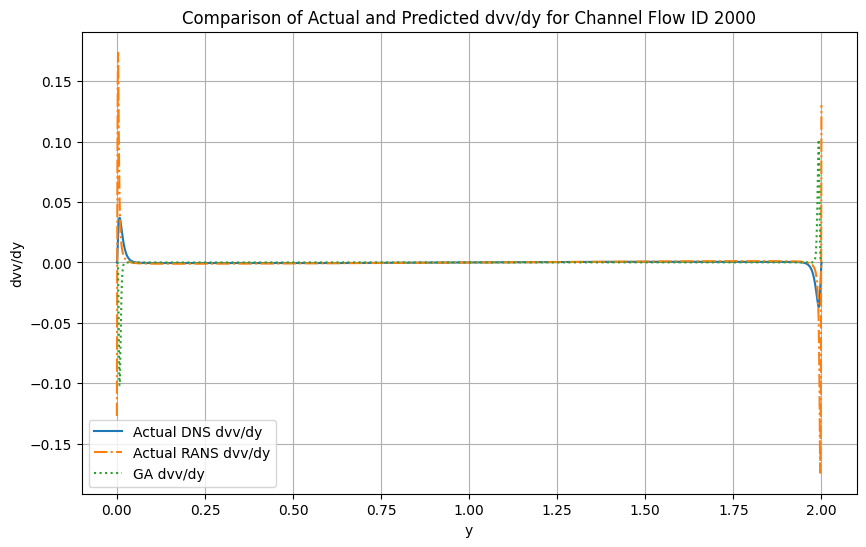

R² Score for GA-based predictions: 0.889427639844997


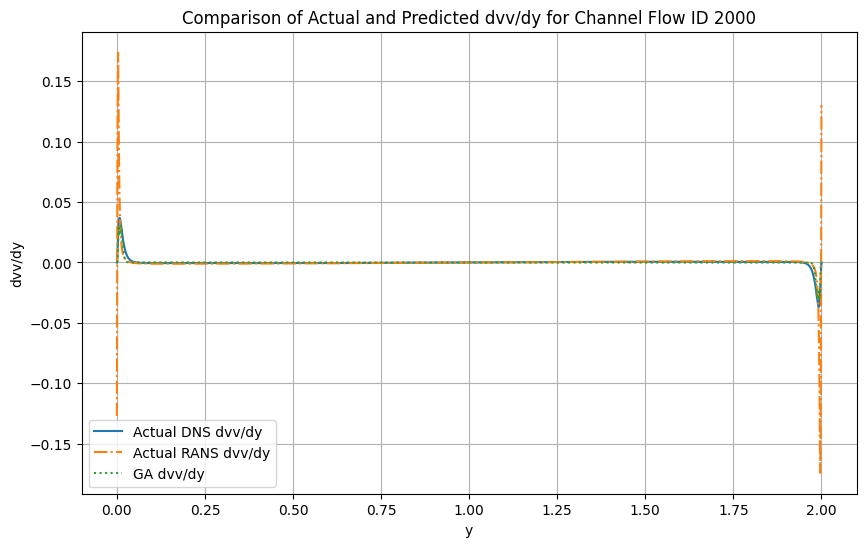

R² Score for GA-based predictions: 0.8174517096225556


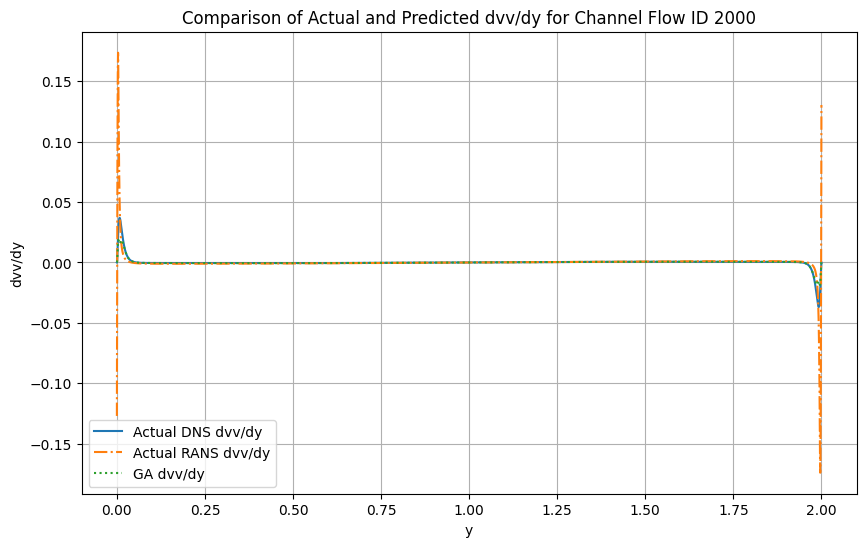

R² Score for GA-based predictions: 0.9759845834091735


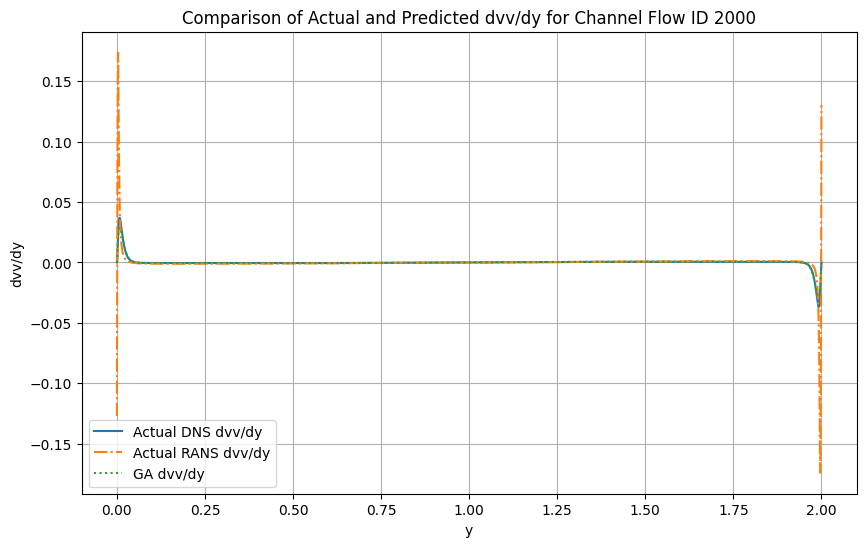

R² Score for GA-based predictions: -9.655691669110967


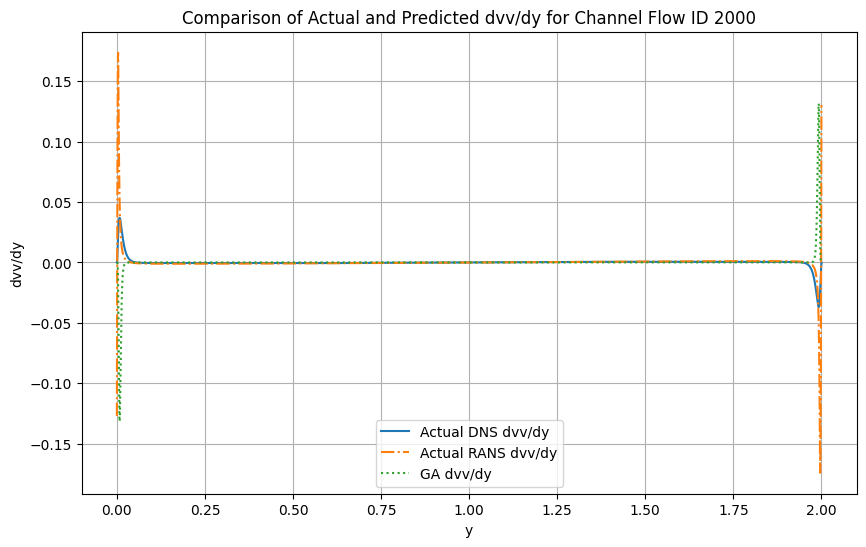

R² Score for GA-based predictions: -6.691500400878666


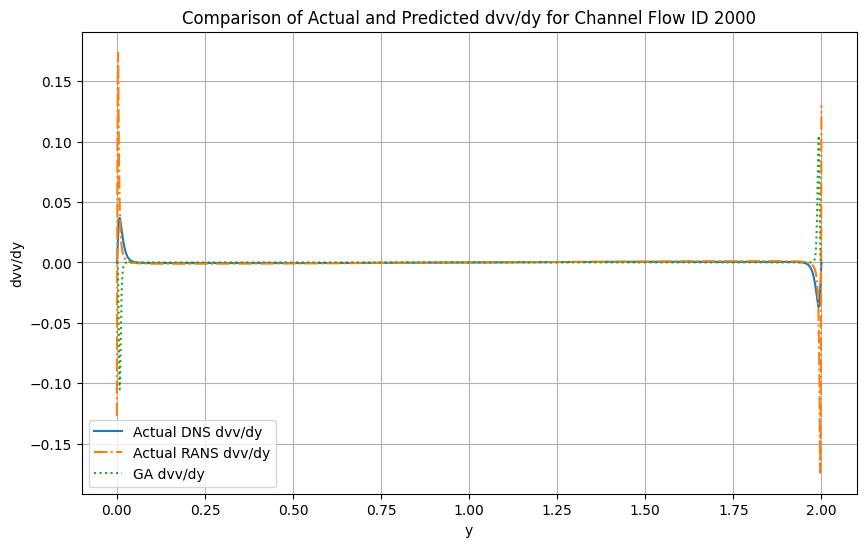

R² Score for GA-based predictions: 0.8359713345141008


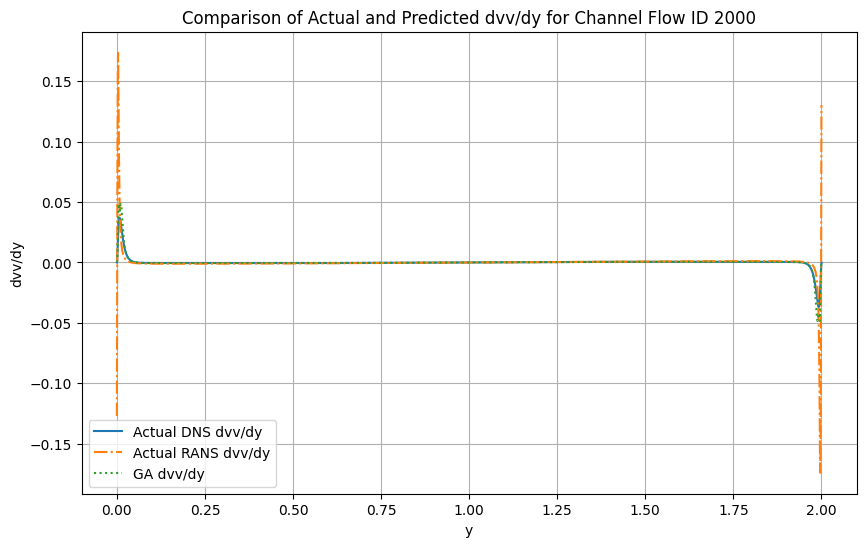

R² Score for GA-based predictions: -0.2760332731540427


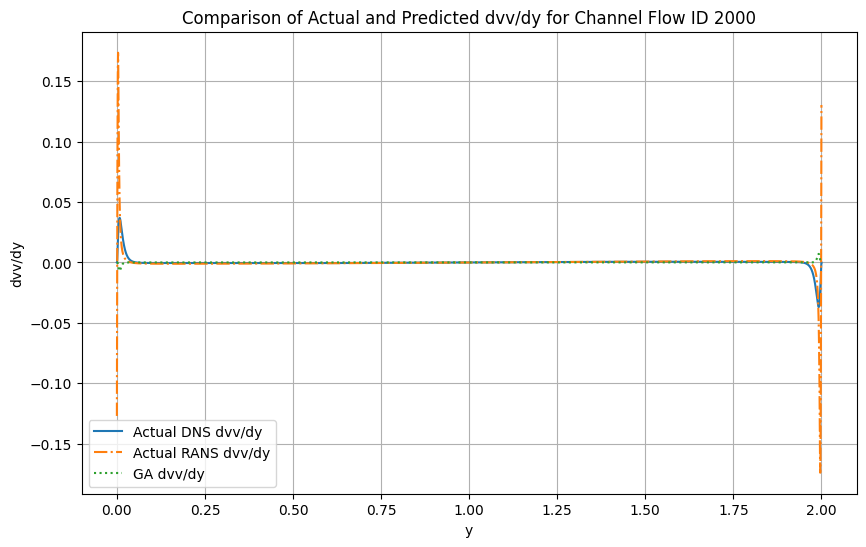

R² Score for GA-based predictions: -6.884703488865879


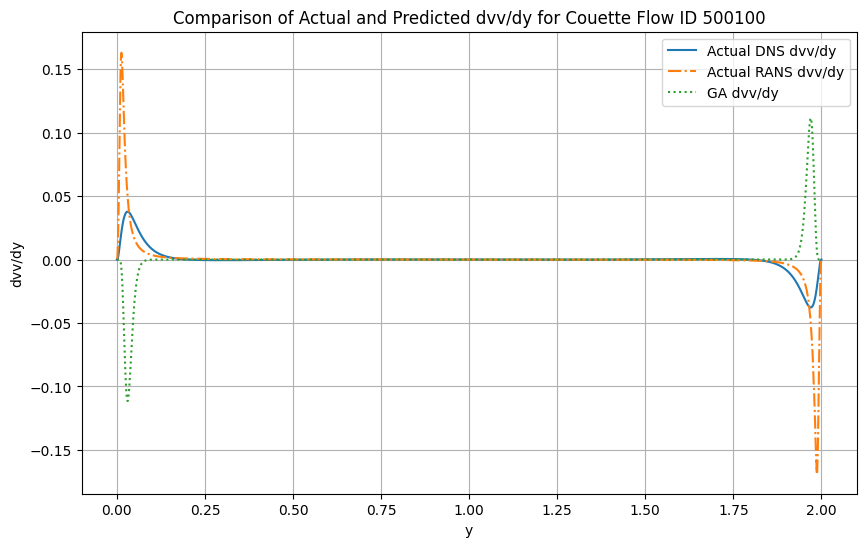

R² Score for GA-based predictions: 0.9362024990697767


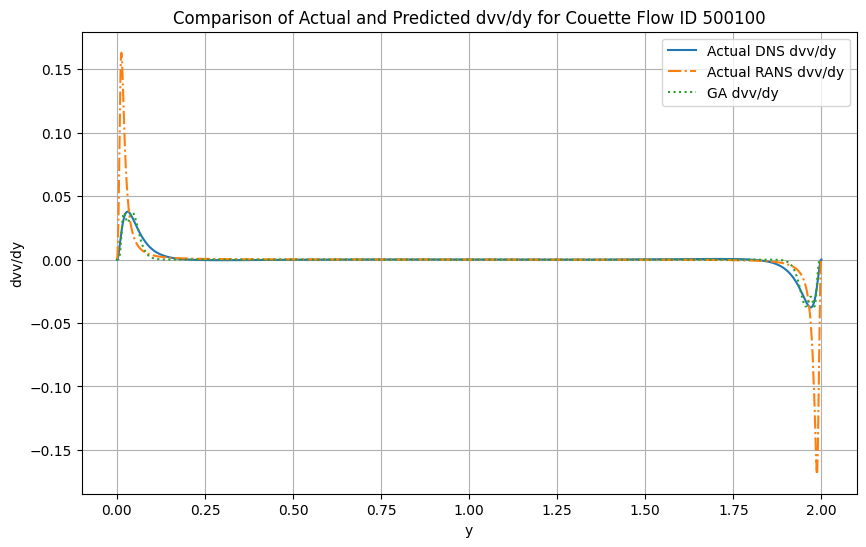

R² Score for GA-based predictions: 0.9870929376771603


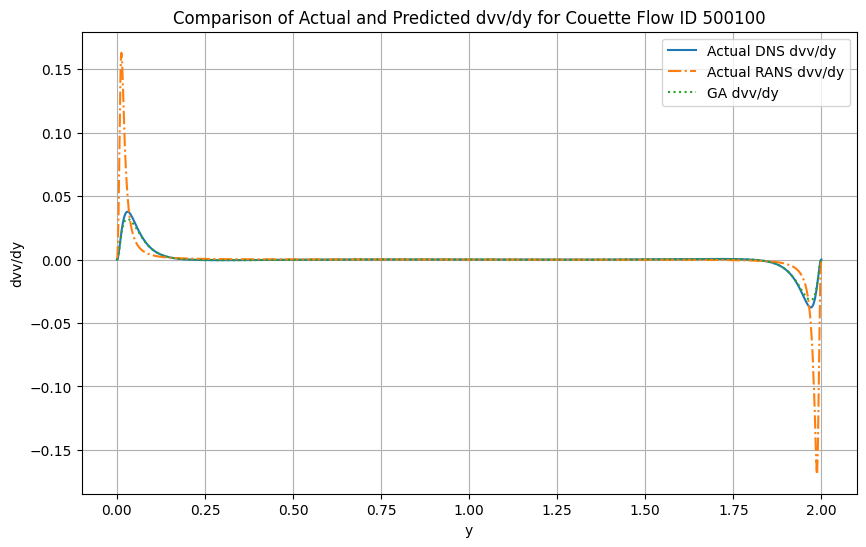

R² Score for GA-based predictions: 0.9974442798290041


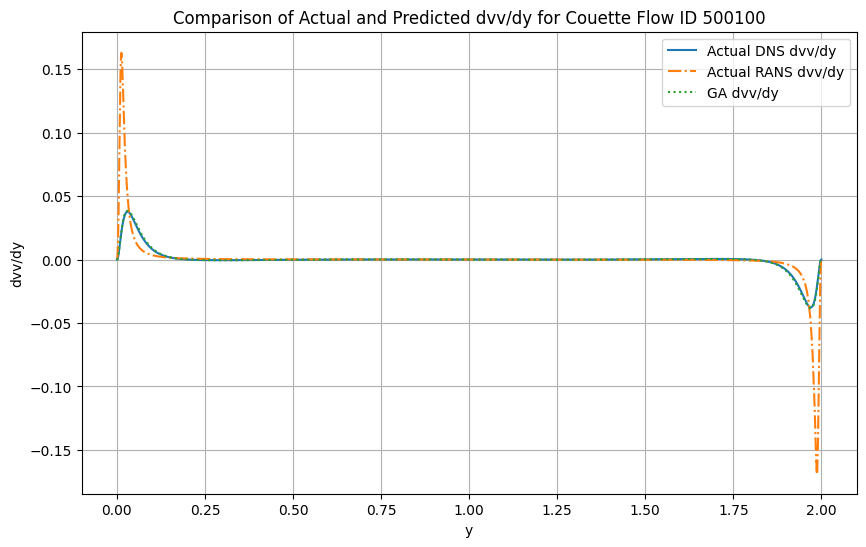

R² Score for GA-based predictions: -7.792185514474628


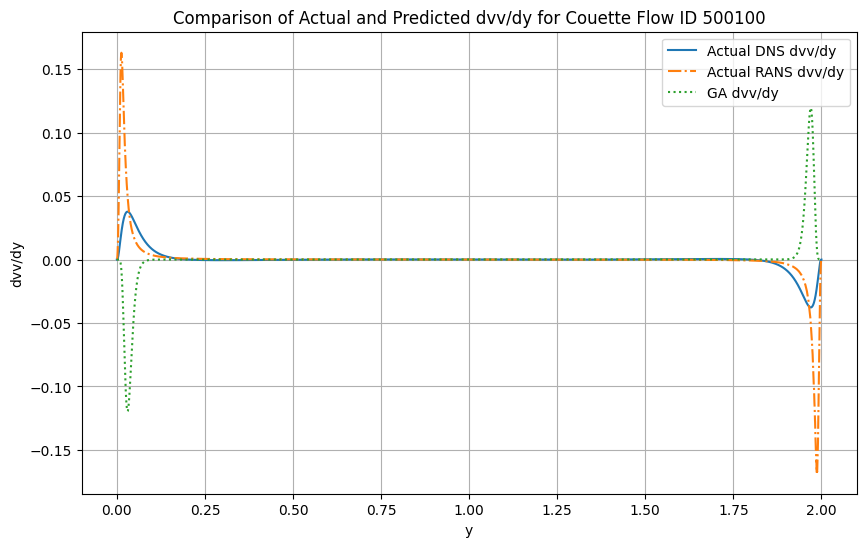

R² Score for GA-based predictions: -6.042379169367173


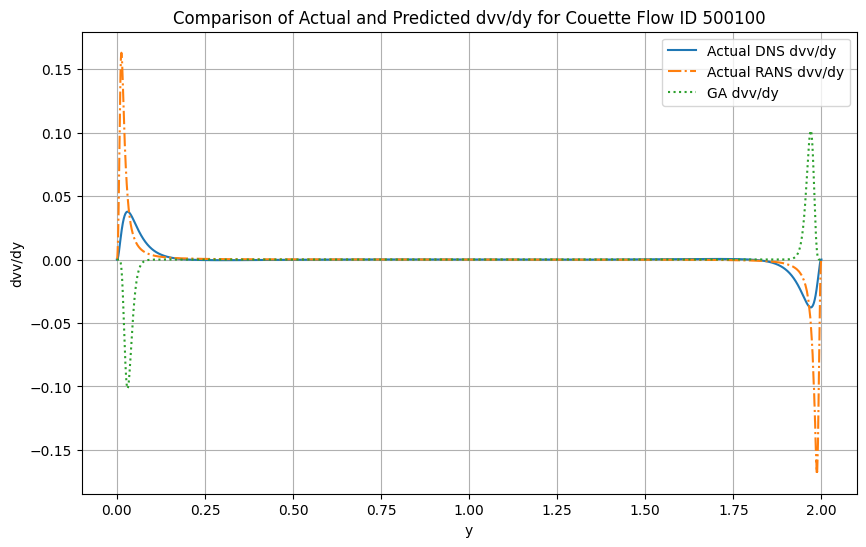

R² Score for GA-based predictions: 0.42804992805367403


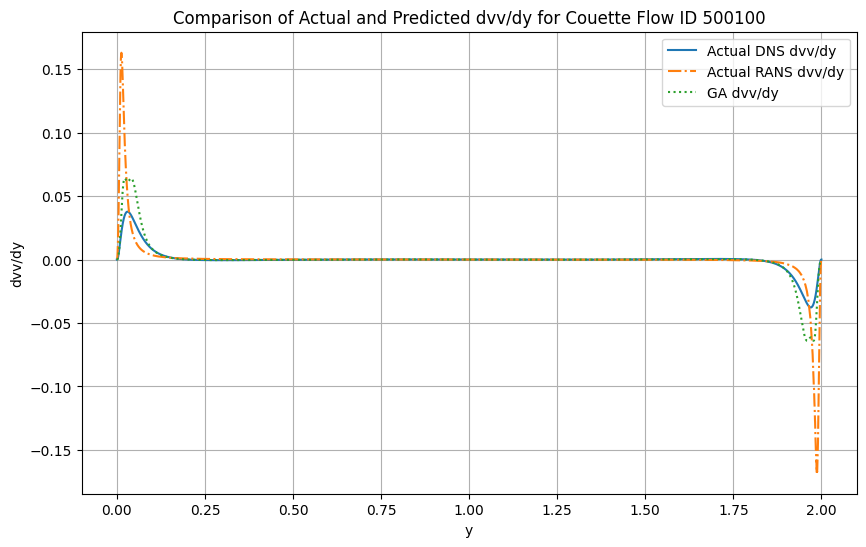

R² Score for GA-based predictions: -0.06869304733203019


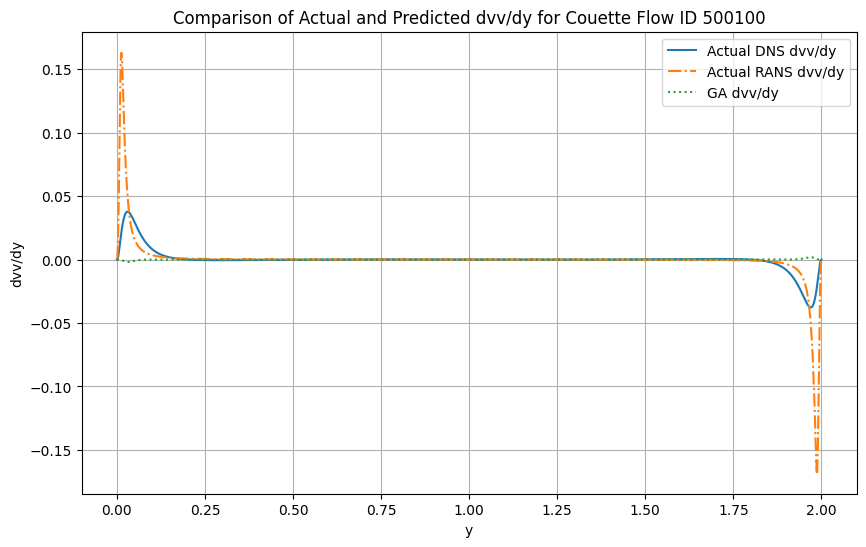

In [41]:
# Plotting for dvv/dy. This will plot the last equation found by the prevous code

# Loop through datasets for plotting. 
for flow_type, ids in test_dataset.items():
    for id in ids:
        filename = channel_int_augmented_datafilenames[id] if flow_type == "Channel" else couette_int_augmented_datafilenames[id]
        int_data = pd.read_csv(filename)

        # If Couette flow, adjust U as before
        if flow_type == "Couette":
            int_data['U'] -= 0

        # Prepare the feature matrix for prediction
        features = construct_features(int_data)
        
        # Predict the gradient of U using the model
        predicted_results = model.predict(features)
        
        # Actual dU_dy values for comparison
        actual_dns_results = int_data[[target]].values
        actual_rans_results = int_data[[rans_target]].values
        

    coefficients_list = [
        [0.23924939403600187, 0.03230573630397371, 1442007, 0],
        [-2665.127, 0.131, 1442007, 0],
        [-0.00983957739602015, 0.21457735441285905, 0.20207379837060926, -1],
        [0.10529795683225056, 0.12206895029124012, -0.8986962693679499, -1.1030703852055932],
        [0.13707543054135093, 0.3304864817117713, 1442007, 0],
        [0.3221425772304375, 0.19116657304720186, 1257020, 0],
        [-2451.492, 0.275678582048276, 1257020, -0.8817128406381584],
        [-0.8735381763275504, 0.07097264614318596, 0.1, 0]
    ]
    for ind, coefficients in enumerate(coefficients_list):
        a,b,c,d = coefficients
        int_data['GA_2'] = a* (int_data['dP_dy']**3) + (b*int_data['dP_dy']**3 *int_data['Re_tau']) + (c* int_data['dP_dy']**5) + (d*int_data['dP_dy'])
        d2U_dy2_GA1 = int_data['GA_2'].values
    

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(int_data['y'], actual_dns_results, label="Actual DNS dvv/dy", linestyle='-')
        plt.plot(int_data['y'], actual_rans_results, label="Actual RANS dvv/dy", linestyle='-.')
        plt.plot(int_data['y'], predicted_results, label="Predicted dvv/dy", linestyle='--')
        #plt.plot(int_data['y'], d2U_dy2_GA1, label="GA dvv/dy", linestyle=':')

        plt.xlabel('y')
        plt.ylabel("dvv/dy")
        plt.title(f"Comparison of Actual and Predicted dvv/dy for {flow_type} Flow ID {id}")
        plt.legend()
        plt.grid(True)
        plt.show()

Model with alpha=0.1, max_iter=1: R²=0.9999998558703806, RMSE=2.20161217905778e-06
(dP_dy)' = -1.000 dP_dy
R² Score for GA-based predictions: 0.8965423101413075
R² Score for GA-based predictions: 0.889427639844997
R² Score for GA-based predictions: 0.934941550537912
R² Score for GA-based predictions: 0.933720962581376
R² Score for GA-based predictions: 0.9370831441126074
R² Score for GA-based predictions: 0.9365154935990522
R² Score for GA-based predictions: 0.9362024990697767


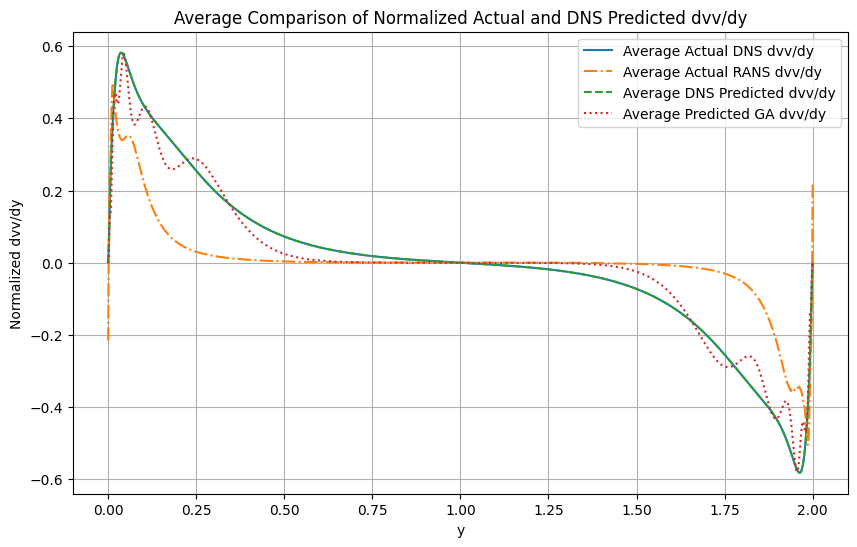

In [45]:
# Averaging tests for dv'v'/dy

# Use a high-degree polynomial feature library
feature_library = ps.PolynomialLibrary(degree=5)

# Initialize lists to hold combined training features and targets
X_train_combined = []
X_dot_train_combined = []

selected_features = {
    #'U': True,
    #'dU/dy': True, 
    #'d2U/dy2': True,
    #'W': True,
    #'dW_dy': True,
    #'d2W/dy2': True,
    #'P': True,
    #'dP_dx': True,
    #'dP_dx_adam': True,
    'dP_dy': True,
    #'d2P/dy2': True,
    #'u\'u\'': True,
    #'duu_dy': True,
    #'d2uu/dy2': True,
    #'v\'v\'': True,
    #'dvv_dy': True,
    #'d2vv/dy2': True,
    #'w\'w\'': True,
    #'dww_dy': True,
    #'d2ww/dy2': True,
    #'u\'v\'': True,
    #'duv_dy': True,
    #'d2uv/dy2': True,
    'Re_tau': True, 
    #'nu': True, 
    #'u_tau': True
}

# Set up variations of parameters
degrees = [5]
alphas = [0.1] 
max_iters = [1]

# Define a list to store models for comparison
models = []
performance_metrics = []   

# Dynamically build feature names list based on selected features
feature_names = [feature for feature in selected_features if selected_features[feature]]

# Function to construct features based on selected_features dictionary
def construct_features(int_data):
    features = np.hstack([int_data[[feature]].values for feature in selected_features if selected_features[feature]])
    return features

# Process each dataset for training
for flow_type, ids in train_dataset.items():
    for id in ids:
        # Determine the correct filenames and parameters based on flow type
        filename = (channel_int_augmented_datafilenames if flow_type == "Channel" else couette_int_augmented_datafilenames)[id]
        params_df_selected = params_df if flow_type == "Channel" else couette_params_df
        params = params_df_selected[params_df_selected[flow_type.lower()] == id].iloc[0]
        
        # Load data
        int_data = pd.read_csv(filename)

        # Append simulation parameters as new columns
        for param in ['Re_tau', 'nu', 'u_tau']:
            int_data[param] = params[param]
        int_data['inv_nu'] = 1/int_data['nu']
        int_data['inv_u_tau'] = 1/int_data['u_tau']
        
        # Compute derivatives and append simulation parameters
        t = int_data['y'].values

        if flow_type == "Couette":
            int_data['U'] -= 0
        
        features = construct_features(int_data)
                              
        targets = int_data[['dvv_dy']].values
        
        # Append features and targets to the training lists
        X_train_combined.append(features)
        X_dot_train_combined.append(targets)

# Combine all the training features and targets from different setups
X_train_combined = np.vstack(X_train_combined)
X_dot_train_combined = np.vstack(X_dot_train_combined)

# Iterate over each combination of alpha and max_iter
for alpha in alphas:
    for max_iter in max_iters:
        optimizer = ps.FROLS(normalize_columns=False, alpha=alpha, max_iter=max_iter)
        model = ps.SINDy(optimizer=optimizer, feature_library=feature_library, feature_names=feature_names)
        model.fit(X_train_combined, x_dot=X_dot_train_combined)
        
        # Predict on a validation/test set
        predicted_dot = model.predict(X_train_combined)
        
        # Calculate R² score or RMSE
        r2 = r2_score(X_dot_train_combined, predicted_dot)
        rmse = np.sqrt(mean_squared_error(X_dot_train_combined, predicted_dot))
        
        # Store model and performance
        models.append((model, r2, rmse))
        performance_metrics.append(r2) 

        print(f"Model with alpha={alpha}, max_iter={max_iter}: R²={r2}, RMSE={rmse}")
        model.print()

# Testing dvv/dy ODE

# Define a common y grid for interpolation
common_y = np.linspace(0, 2, 1000) 

# Initialize lists to hold interpolated curve data for averaging
all_actual_dns = []
all_actual_rans = []
all_predicted = []
all_predicted_ga= []

for flow_type, ids in test_dataset.items():
    for id in ids:
        filename = channel_int_augmented_datafilenames[id] if flow_type == "Channel" else couette_int_augmented_datafilenames[id]
        int_data = pd.read_csv(filename)

        if flow_type == "Couette":
            int_data['U'] -= 0

        features = construct_features(int_data)
        predicted_results = model.predict(features)

        coefficients_list = [
        [0.23924939403600187, 0.03230573630397371, 1442007, 0],
        [-2665.127, 0.131, 1442007, 0],
        [-0.00983957739602015, 0.21457735441285905, 0.20207379837060926, -1],
        [0.10529795683225056, 0.12206895029124012, -0.8986962693679499, -1.1030703852055932],
        [0.13707543054135093, 0.3304864817117713, 1442007, 0],
        [0.3221425772304375, 0.19116657304720186, 1257020, 0],
        [-2451.492, 0.275678582048276, 1257020, -0.8817128406381584],
        [-0.8735381763275504, 0.07097264614318596, 0.1, 0]
        ]
    
        a,b,c,d = coefficients_list[1]
        int_data['GA_2'] = a* (int_data['dP_dy']**3) + (b*int_data['dP_dy']**3 *int_data['Re_tau']) + (c* int_data['dP_dy']**5) + (d*int_data['dP_dy'])
        d2U_dy2_GA1 = int_data['GA_2'].values
        r2_ga = r2_score(int_data[['dvv_dy']].values, d2U_dy2_GA1)
        print("R² Score for GA-based predictions:", r2_ga)

        actual_dns_results = int_data[['dvv_dy']].values.flatten()
        actual_rans_results = int_data[['rans_dvv_dy']].values.flatten()
        ga_results = d2U_dy2_GA1.flatten()
        # Interpolate to the common y grid using cubic spline
        spline_actual_dns = CubicSpline(int_data['y'], actual_dns_results, bc_type='natural', extrapolate=True)
        spline_actual_rans = CubicSpline(int_data['y'], actual_rans_results, bc_type='natural', extrapolate=True)
        spline_predicted = CubicSpline(int_data['y'], predicted_results.flatten(), bc_type='natural', extrapolate=True)
        spline_predicted_ga = CubicSpline(int_data['y'],ga_results, bc_type='natural', extrapolate=True)

        # Evaluate interpolation on the common y grid
        norm_actual_dns = spline_actual_dns(common_y)
        norm_actual_rans = spline_actual_rans(common_y)
        norm_predicted = spline_predicted(common_y)
        norm_predicted_ga = spline_predicted_ga(common_y)
        # Normalize the data
        norm_actual_dns /= np.max(np.abs(norm_actual_dns))
        norm_actual_rans /= np.max(np.abs(norm_actual_rans))
        norm_predicted /= np.max(np.abs(norm_predicted))
        norm_predicted_ga /= np.max(np.abs(norm_predicted_ga))
        all_actual_dns.append(norm_actual_dns)
        all_actual_rans.append(norm_actual_rans)
        all_predicted.append(norm_predicted)
        all_predicted_ga.append(norm_predicted_ga)


# Convert lists to arrays
all_actual_dns = np.array(all_actual_dns)
all_actual_rans = np.array(all_actual_rans)
all_predicted = np.array(all_predicted)
all_predicted_ga = np.array(all_predicted_ga)

# Calculate average curves
average_actual_dns = np.mean(all_actual_dns, axis=0)
average_actual_rans = np.mean(all_actual_rans, axis=0)
average_predicted = np.mean(all_predicted, axis=0)
average_ga  = np.mean(all_predicted_ga, axis=0)
# Create a DataFrame to store the results along with the common y values
results_df = pd.DataFrame({
    'y': common_y,
    'Average Actual DNS dvv/dy': average_actual_dns,
    'Average Actual RANS dvv/dy': average_actual_rans,
    'Average Predicted dvv/dy': average_predicted,
    'average Predicted dvv/dy GA': average_ga
})

# Save to CSV
results_df.to_csv('Results/average_dvv_dy_results.csv', index=False)

# Plotting the average curves
plt.figure(figsize=(10, 6))
plt.plot(common_y, average_actual_dns, label="Average Actual DNS dvv/dy", linestyle='-')
plt.plot(common_y, average_actual_rans, label="Average Actual RANS dvv/dy", linestyle='-.')
plt.plot(common_y, average_predicted, label="Average DNS Predicted dvv/dy", linestyle='--')
plt.plot(common_y, average_ga, label="Average Predicted GA dvv/dy", linestyle=':')

plt.xlabel('y')
plt.ylabel("Normalized dvv/dy")
plt.title("Average Comparison of Normalized Actual and DNS Predicted dvv/dy")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Training the model for d2U/dy2

selected_features = {
    #'U': True,
    #'dU/dy': True,  # predicting this, so not a feature
    #'d2U/dy2': True,
    #'W': True,
    #'dW_dy': True,
    #'d2W/dy2': True,
    #'P': True,
    #'dP_dx': True,
    'dP_dx_adam': True,
    #'dP_dy': True,
    #'d2P/dy2': True,
    #'u\'u\'': True,
    #'duu_dy': True,
    #'d2uu/dy2': True,
    #'v\'v\'': True,
    #'dvv_dy': True,
    #'d2vv/dy2': True,
    #'w\'w\'': True,
    #'dww_dy': True,
    #'d2ww/dy2': True,
    #'u\'v\'': True,
    'duv_dy': True,
    #'d2uv/dy2': True,
    #'Re_tau': True, 
    #'nu': True, #for best test r squared
    #'u_tau': True
    #'inv_nu': True,
    #'inv_u_tau': True,
}

target = 'd2U_dy2'
rans_target = 'd2xdy2'

# Set up variations of parameters
degrees = [1,2,3,4,5]
alphas = [0.1, 0.01]
max_iters = [1,2,3,4,5,6,7,8,9,10]

# Initialize lists to hold combined training features and targets
X_train_combined = []
X_dot_train_combined = []
X_test_combined = []
X_dot_test_combined = []

# Define a list to store models for comparison
models = []
performance_metrics = []    

# Dynamically build feature names list based on selected features
feature_names = [feature for feature in selected_features if selected_features[feature]]

# Function to construct features based on selected_features dictionary
def construct_features(int_data):
    features = np.hstack([int_data[[feature]].values for feature in selected_features if selected_features[feature]])
    return features

# Process each dataset for training and testing
for dataset_type, dataset in {'train': train_dataset, 'test': test_dataset}.items():
    for flow_type, ids in dataset.items():
        for id in ids:
            filename = channel_int_augmented_datafilenames[id] if flow_type == "Channel" else couette_int_augmented_datafilenames[id]
            params_df_selected = params_df if flow_type == "Channel" else couette_params_df
            params = params_df_selected[params_df_selected[flow_type.lower()] == id].iloc[0]

            int_data = pd.read_csv(filename)

            # Append simulation parameters as new columns
            for param in ['Re_tau', 'nu', 'u_tau']:
                int_data[param] = params[param]
            int_data['inv_nu'] = 1/int_data['nu']
            int_data['inv_u_tau'] = 1/int_data['u_tau']

            # Construct features
            features = construct_features(int_data)

            # Extract target values for the model
            if 'd2U_dy2' in int_data.columns:
                targets = int_data[[target]].values
            else:
                continue  # Skip this dataset if the target variable isn't available

            # Depending on the dataset type, append data to the corresponding list
            if dataset_type == 'train':
                X_train_combined.append(features)
                X_dot_train_combined.append(targets)
            elif dataset_type == 'test':
                X_test_combined.append(features)
                X_dot_test_combined.append(targets)

# Convert lists of arrays to single numpy arrays
X_train_combined = np.vstack(X_train_combined)
X_dot_train_combined = np.vstack(X_dot_train_combined)
X_test_combined = np.vstack(X_test_combined)
X_dot_test_combined = np.vstack(X_dot_test_combined)

results = []  # List to store the results

# Iterate over each combination of degree, alpha and max_iter
for degree in degrees:
    for alpha in alphas:
        for max_iter in max_iters:
            # Initialize and fit the model
            optimizer = ps.FROLS(normalize_columns=False, alpha=alpha, max_iter=max_iter)
            feature_library = ps.PolynomialLibrary(degree)
            model = ps.SINDy(optimizer=optimizer, feature_library=feature_library, feature_names=feature_names)
            model.fit(X_train_combined, x_dot=X_dot_train_combined)
            
            # Predict and compute metrics on training set
            predicted_dot_train = model.predict(X_train_combined)
            r2_train = r2_score(X_dot_train_combined, predicted_dot_train)
            rmse_train = np.sqrt(mean_squared_error(X_dot_train_combined, predicted_dot_train))
            
            # Predict and compute metrics on testing set
            predicted_dot_test = model.predict(X_test_combined)
            r2_test = r2_score(X_dot_test_combined, predicted_dot_test)
            rmse_test = np.sqrt(mean_squared_error(X_dot_test_combined, predicted_dot_test))
            
            # Redirect stdout to capture the equation print
            old_stdout = sys.stdout
            sys.stdout = io.StringIO()
            model.print()
            equation = sys.stdout.getvalue()
            sys.stdout = old_stdout
            equation = ' '.join(equation.split())
            
            # Store results
            results.append([degree, alpha, max_iter, equation, r2_train, rmse_train, r2_test, rmse_test])
            print(f"Model with degree={degree}, alpha={alpha}, max_iter={max_iter}: R²_train={r2_train}, R²_test={r2_test}, RMSE_train={rmse_train}, RMSE_test={rmse_test}")

# Convert results to DataFrame and sort by R2 Test in descending order
columns = ['Degree', 'Alpha', 'Iters', 'Equation', 'R2 Train', 'RMSE Train', 'R2 Test', 'RMSE Test']
results_df = pd.DataFrame(results, columns=columns)
results_df = results_df.sort_values(by='R2 Test', ascending=False)

# Save to CSV
csv_filename = f"results\model_results_final2_{target}.csv"
results_df.to_csv(csv_filename, index=False)

Model with degree=1, alpha=0.1, max_iter=1: R²_train=0.9406197887367395, R²_test=0.992689972366322, RMSE_train=0.001767009888919982, RMSE_test=0.0009644583200846439
Model with degree=1, alpha=0.1, max_iter=2: R²_train=0.9577964567871573, R²_test=0.9949590902474875, RMSE_train=0.0014896785615002549, RMSE_test=0.000800900225202118
Model with degree=1, alpha=0.1, max_iter=3: R²_train=0.9577964567871573, R²_test=0.9949590902474875, RMSE_train=0.0014896785615002549, RMSE_test=0.000800900225202118
Model with degree=1, alpha=0.1, max_iter=4: R²_train=0.9577964567871573, R²_test=0.9949590902474875, RMSE_train=0.0014896785615002549, RMSE_test=0.000800900225202118
Model with degree=1, alpha=0.1, max_iter=5: R²_train=0.9577964567871573, R²_test=0.9949590902474875, RMSE_train=0.0014896785615002549, RMSE_test=0.000800900225202118
Model with degree=1, alpha=0.1, max_iter=6: R²_train=0.9577964567871573, R²_test=0.9949590902474875, RMSE_train=0.0014896785615002549, RMSE_test=0.000800900225202118
Model

c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07068e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.1, max_iter=7: R²_train=0.9839621870368318, R²_test=0.9930005738209581, RMSE_train=0.0009183128954677934, RMSE_test=0.0009437461074796152


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07068e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07175e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.1, max_iter=8: R²_train=0.9839621870368318, R²_test=0.9930005738209581, RMSE_train=0.0009183128954677934, RMSE_test=0.0009437461074796152


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07068e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07175e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.1, max_iter=9: R²_train=0.9839621870368318, R²_test=0.9930005738209581, RMSE_train=0.0009183128954677934, RMSE_test=0.0009437461074796152


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07068e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07175e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.06017e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.1, max_iter=10: R²_train=0.9839621870368318, R²_test=0.9930005738209581, RMSE_train=0.0009183128954677934, RMSE_test=0.0009437461074796152
Model with degree=4, alpha=0.01, max_iter=1: R²_train=0.9406197887367395, R²_test=0.992689972366322, RMSE_train=0.001767009888919982, RMSE_test=0.0009644583200846439
Model with degree=4, alpha=0.01, max_iter=2: R²_train=0.9618303860541242, R²_test=0.9920042208992043, RMSE_train=0.001416697066170125, RMSE_test=0.00100868217981175
Model with degree=4, alpha=0.01, max_iter=3: R²_train=0.9733805024591498, R²_test=0.9949094520460228, RMSE_train=0.0011830906922174179, RMSE_test=0.0008048338264166345
Model with degree=4, alpha=0.01, max_iter=4: R²_train=0.9793638496229436, R²_test=0.9951329597679216, RMSE_train=0.001041675507238351, RMSE_test=0.0007869668211998839


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11995e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.01, max_iter=5: R²_train=0.9817396212644134, R²_test=0.9954406522065637, RMSE_train=0.0009798802431076024, RMSE_test=0.0007616848467275966


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11995e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11837e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.01, max_iter=6: R²_train=0.9836772664017374, R²_test=0.9923607218089715, RMSE_train=0.0009264341533464708, RMSE_test=0.0009859391620695936


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11995e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11837e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03417e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.01, max_iter=7: R²_train=0.9839621870368318, R²_test=0.9930005738209581, RMSE_train=0.0009183128954677934, RMSE_test=0.0009437461074796152


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11995e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11837e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03417e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03459e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=4, alpha=0.01, max_iter=8: R²_train=0.9839621870368318, R²_test=0.9930005738209581, RMSE_train=0.0009183128954677934, RMSE_test=0.0009437461074796152


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11995e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11837e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03417e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03459e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:21

Model with degree=4, alpha=0.01, max_iter=9: R²_train=0.9839621870368318, R²_test=0.9930005738209581, RMSE_train=0.0009183128954677934, RMSE_test=0.0009437461074796152


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11995e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11837e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03417e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03459e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:21

Model with degree=4, alpha=0.01, max_iter=10: R²_train=0.9839621870368318, R²_test=0.9930005738209581, RMSE_train=0.0009183128954677934, RMSE_test=0.0009437461074796152
Model with degree=5, alpha=0.1, max_iter=1: R²_train=0.9406197887367395, R²_test=0.992689972366322, RMSE_train=0.001767009888919982, RMSE_test=0.0009644583200846439
Model with degree=5, alpha=0.1, max_iter=2: R²_train=0.9618303860541242, R²_test=0.9920042208992043, RMSE_train=0.001416697066170125, RMSE_test=0.00100868217981175
Model with degree=5, alpha=0.1, max_iter=3: R²_train=0.975593848554275, R²_test=0.9954135355265963, RMSE_train=0.001132837877743897, RMSE_test=0.0007639465457396822
Model with degree=5, alpha=0.1, max_iter=4: R²_train=0.9812605713775405, R²_test=0.995668152234274, RMSE_train=0.0009926503115340558, RMSE_test=0.0007424386074983995


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.84015e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.1, max_iter=5: R²_train=0.9831826519867788, R²_test=0.9959968483065568, RMSE_train=0.0009403658878339698, RMSE_test=0.0007137152530257342


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.84015e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70732e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.1, max_iter=6: R²_train=0.9843212817642831, R²_test=0.9951515240595868, RMSE_train=0.0009079739496536866, RMSE_test=0.0007854645283559714


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.84015e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70732e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.74124e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.1, max_iter=7: R²_train=0.9843212817642831, R²_test=0.9951515240595868, RMSE_train=0.0009079739496536866, RMSE_test=0.0007854645283559714


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.84015e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70732e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.74124e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.74014e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.1, max_iter=8: R²_train=0.9855663736257951, R²_test=0.9907173999469869, RMSE_train=0.0008711758751993783, RMSE_test=0.0010868228835564135


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.84015e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70732e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.74124e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.74014e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:21

Model with degree=5, alpha=0.1, max_iter=9: R²_train=0.9855663736257951, R²_test=0.9907173999469869, RMSE_train=0.0008711758751993783, RMSE_test=0.0010868228835564135


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.84015e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70732e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.74124e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.74014e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:21

Model with degree=5, alpha=0.1, max_iter=10: R²_train=0.9855663736257951, R²_test=0.9907173999469869, RMSE_train=0.0008711758751993783, RMSE_test=0.0010868228835564135
Model with degree=5, alpha=0.01, max_iter=1: R²_train=0.9406197887367395, R²_test=0.992689972366322, RMSE_train=0.001767009888919982, RMSE_test=0.0009644583200846439
Model with degree=5, alpha=0.01, max_iter=2: R²_train=0.9618303860541242, R²_test=0.9920042208992043, RMSE_train=0.001416697066170125, RMSE_test=0.00100868217981175
Model with degree=5, alpha=0.01, max_iter=3: R²_train=0.975593848554275, R²_test=0.9954135355265963, RMSE_train=0.001132837877743897, RMSE_test=0.0007639465457396822
Model with degree=5, alpha=0.01, max_iter=4: R²_train=0.9812605713775405, R²_test=0.995668152234274, RMSE_train=0.0009926503115340558, RMSE_test=0.0007424386074983995


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.83765e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=5: R²_train=0.9831826519867788, R²_test=0.9959968483065568, RMSE_train=0.0009403658878339698, RMSE_test=0.0007137152530257342


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.83765e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.69764e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=6: R²_train=0.9843212817642831, R²_test=0.9951515240595868, RMSE_train=0.0009079739496536866, RMSE_test=0.0007854645283559714


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.83765e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.69764e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70511e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=7: R²_train=0.9843212817642831, R²_test=0.9951515240595868, RMSE_train=0.0009079739496536866, RMSE_test=0.0007854645283559714


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.83765e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.69764e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70511e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70478e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=8: R²_train=0.9855663736257951, R²_test=0.9907173999469869, RMSE_train=0.0008711758751993783, RMSE_test=0.0010868228835564135


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.83765e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.69764e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70511e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70478e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:21

Model with degree=5, alpha=0.01, max_iter=9: R²_train=0.9855663736257951, R²_test=0.9907173999469869, RMSE_train=0.0008711758751993783, RMSE_test=0.0010868228835564135


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.83765e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.69764e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70511e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70478e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with degree=5, alpha=0.01, max_iter=10: R²_train=0.9855663736257951, R²_test=0.9907173999469869, RMSE_train=0.0008711758751993783, RMSE_test=0.0010868228835564135


c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70478e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.7047e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


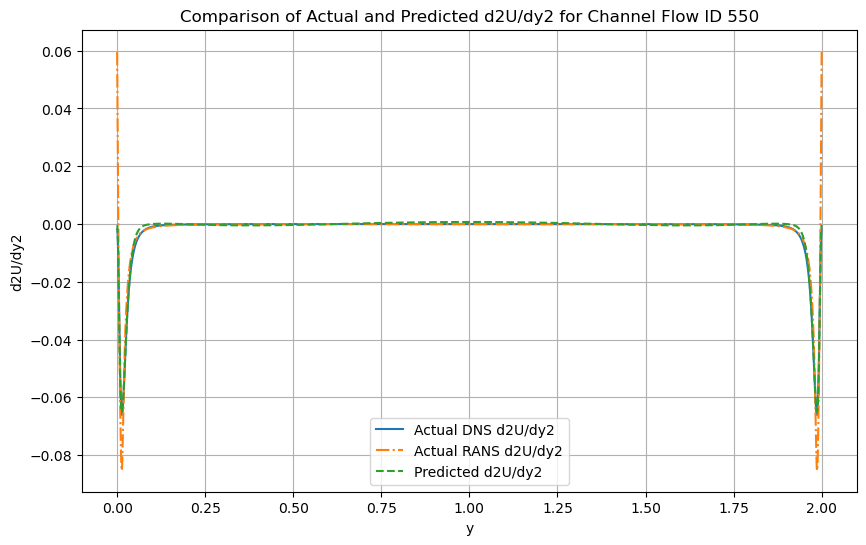

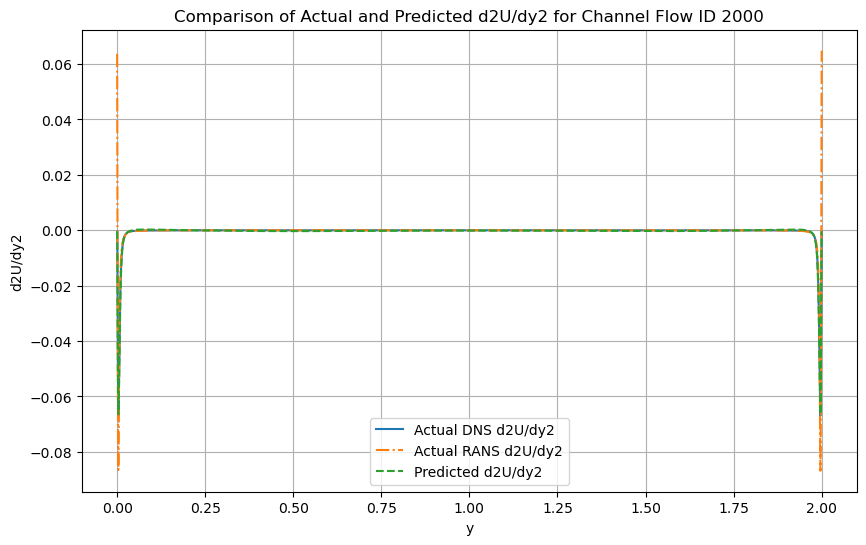

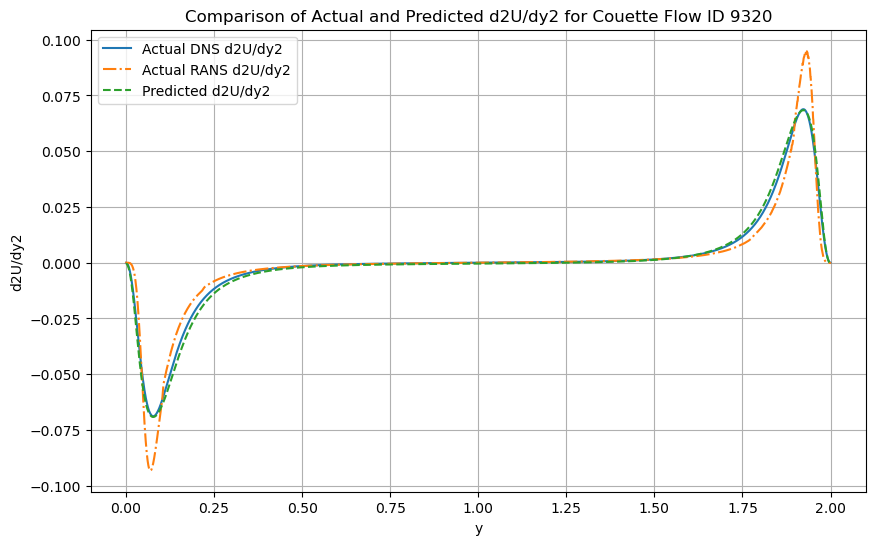

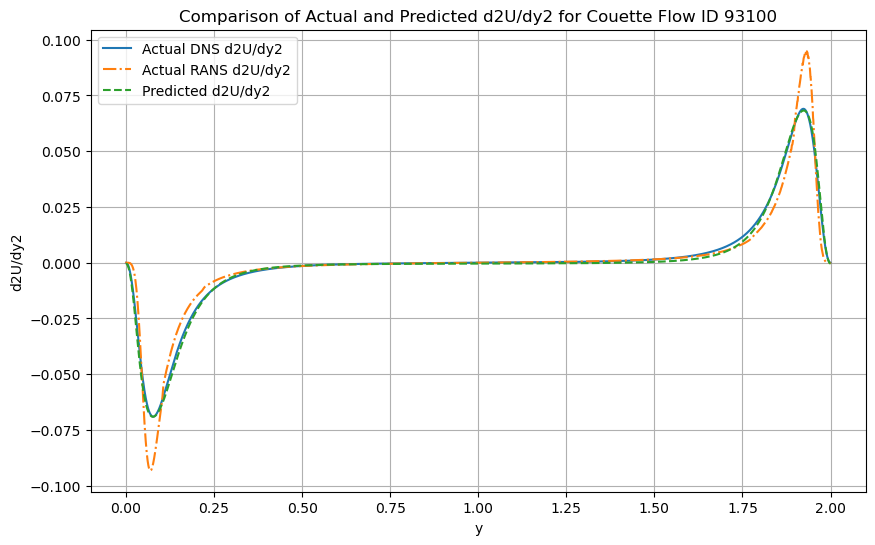

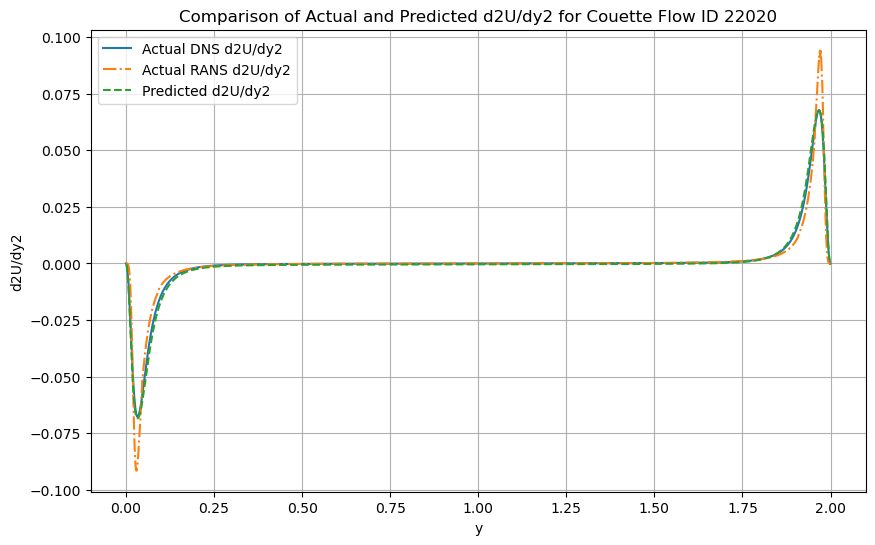

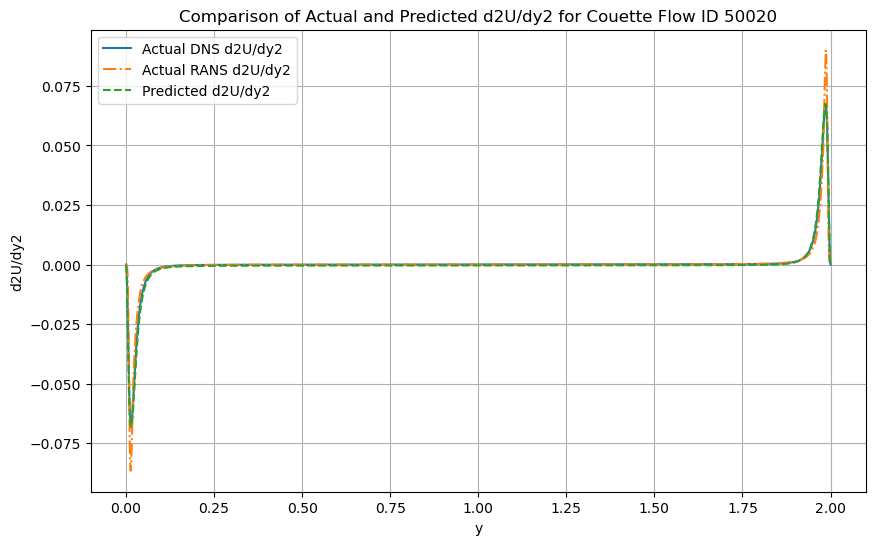

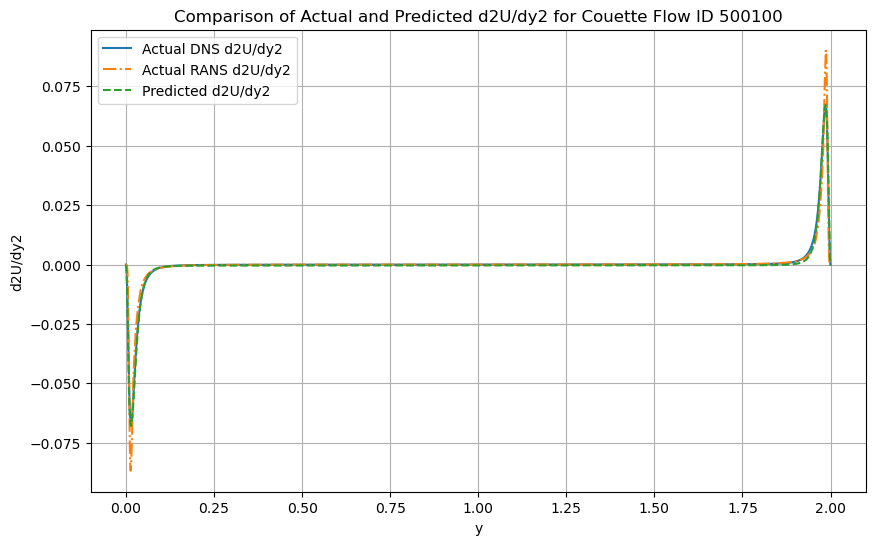

In [16]:
# # Plotting for d²U/dy². This will plot the last equation found by the prevous code
# Loop through datasets for plotting
for flow_type, ids in test_dataset.items():
    for id in ids:
        filename = channel_int_augmented_datafilenames[id] if flow_type == "Channel" else couette_int_augmented_datafilenames[id]
        int_data = pd.read_csv(filename)

        # If Couette flow, adjust U as before
        if flow_type == "Couette":
            int_data['U'] -= 0

        # Prepare the feature matrix for prediction
        features = construct_features(int_data)
        
        # Predict the gradient of U using the model
        predicted_results = model.predict(features)

        # Actual dU_dy values for comparison
        actual_results = int_data[target].values

        # RANS d2U/dy2
        d2xdy2 = int_data[[rans_target]].values

        # Variables preparation for equations (GA and RANS)
        inv_nu = int_data['inv_nu'].values
        dP_dx = int_data['dP_dx'].values
        duv_dy = int_data['duv_dy'].values
        Re_tau = int_data['Re_tau'].values
        u_tau = int_data['u_tau'].values
        
        # GENETIC ALGORITHM RESULTS FOR d2U/dy2
        int_data['GA'] = 3.9177481222260013* 1 - 2.3221808267828843 * Re_tau + 18.126205182828986 * duv_dy * Re_tau 
        - 475.53953737447364 * duv_dy * Re_tau * u_tau
 
        a = -1.5493596611035807
        b = 0.83572085694466
        c = -1.3215722048995031
        d = 44.076
        e = -481.304
 
        int_data['GA_2'] = a + b * Re_tau + c * u_tau + d * duv_dy * Re_tau + e * duv_dy * Re_tau * u_tau
 
        d2U_dy2_GA1 = int_data['GA_2'].values
        # Calculate R² score for GA predictions
        r2_ga = r2_score(actual_results, d2U_dy2_GA1)
        print("R² Score for GA-based predictions:", r2_ga)

        # RANS Equation to compare with ours (very different)
        int_data['Rans_eq']= inv_nu * (dP_dx + duv_dy)
        Rans_equation = int_data['Rans_eq'].values
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(int_data['y'], actual_results, label="Actual DNS d2U/dy2", linestyle='-')
        plt.plot(int_data['y'], d2xdy2, label="Actual RANS d2U/dy2", linestyle='-.')
        plt.plot(int_data['y'], predicted_results, label="Predicted d2U/dy2", linestyle='--')
        #plt.plot(int_data['y'], Rans_equation, label="Rans equation", linestyle='--')       # Plot or not the RANS equation. Compare with UNNORMALIZED DATA as this is the GA results from improving an unnormalized equation.
        #plt.plot(int_data['y'], d2U_dy2_GA1, label = "GA algorithm", linestyle = '--')      # Plot or not the Genetic Algoritm. Better to compare with UNNORMALIZED DATA.
        plt.xlabel('y')
        plt.ylabel("d2U/dy2")
        plt.title(f"Comparison of Actual and Predicted d2U/dy2 for {flow_type} Flow ID {id}")
        plt.legend()
        plt.grid(True)
        plt.show()

c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.84015e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lystm\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70732e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model with alpha=0.1, max_iter=6: R²=0.9843212817642831, RMSE=0.0009079739496536866
(dP_dx_adam)' = 1.158 duv_dy + -3162.796 dP_dx_adam^2 duv_dy + -33.568 duv_dy^3 + -70937.181 dP_dx_adam^3 duv_dy + 4945608.706 dP_dx_adam^3 duv_dy^2


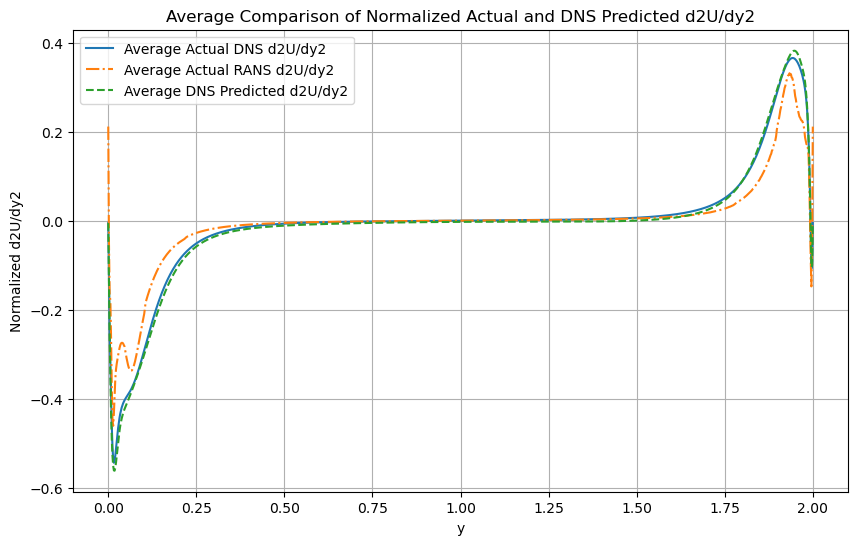

In [15]:
# Averaging tests for d2U/dy2

# Use a high-degree polynomial feature library
feature_library = ps.PolynomialLibrary(degree=5)

# Initialize lists to hold combined training features and targets
X_train_combined = []
X_dot_train_combined = []

selected_features = {
    #'U': True,
    #'dU/dy': True, 
    #'d2U/dy2': True,
    #'W': True,
    #'dW_dy': True,
    #'d2W/dy2': True,
    #'P': True,
    #'dP_dx': True,
    'dP_dx_adam': True,
    #'dP_dy': True,
    #'d2P/dy2': True,
    #'u\'u\'': True,
    #'duu_dy': True,
    #'d2uu/dy2': True,
    #'v\'v\'': True,
    #'dvv_dy': True,
    #'d2vv/dy2': True,
    #'w\'w\'': True,
    #'dww_dy': True,
    #'d2ww/dy2': True,
    #'u\'v\'': True,
    'duv_dy': True,
    #'d2uv/dy2': True,
    #'nu': True, 
    #'u_tau': True
    #'inv_nu': True,
    #'inv_u_tau': True,
}

# Set up variations of parameters
degrees = [5]
alphas = [0.1]  # Example regularization strengths
max_iters = [6]     # Example maximum iterations


# Define a list to store models for comparison
models = []
performance_metrics = []    

# Dynamically build feature names list based on selected features
feature_names = [feature for feature in selected_features if selected_features[feature]]

# Function to construct features based on selected_features dictionary
def construct_features(int_data):
    features = np.hstack([int_data[[feature]].values for feature in selected_features if selected_features[feature]])
    return features

# Process each dataset for training
for flow_type, ids in train_dataset.items():
    for id in ids:
        # Determine the correct filenames and parameters based on flow type
        filename = (channel_int_augmented_datafilenames if flow_type == "Channel" else couette_int_augmented_datafilenames)[id]
        params_df_selected = params_df if flow_type == "Channel" else couette_params_df
        params = params_df_selected[params_df_selected[flow_type.lower()] == id].iloc[0]
        
        # Load data
        int_data = pd.read_csv(filename)

        # Append simulation parameters as new columns
        for param in ['Re_tau', 'nu', 'u_tau']:
            int_data[param] = params[param]
        int_data['inv_nu'] = 1/int_data['nu']
        int_data['inv_u_tau'] = 1/int_data['u_tau']

        # Compute derivatives and append simulation parameters
        t = int_data['y'].values

        if flow_type == "Couette":
            int_data['U'] -= 0
        
        features = construct_features(int_data)
                              
        targets = int_data[['d2U_dy2']].values
        
        # Append features and targets to the training lists
        X_train_combined.append(features)
        X_dot_train_combined.append(targets)

# Combine all the training features and targets from different setups
X_train_combined = np.vstack(X_train_combined)
X_dot_train_combined = np.vstack(X_dot_train_combined)

# Iterate over each combination of alpha and max_iter
for alpha in alphas:
    for max_iter in max_iters:
        optimizer = ps.FROLS(normalize_columns=False, alpha=alpha, max_iter=max_iter)
        model = ps.SINDy(optimizer=optimizer, feature_library=feature_library, feature_names=feature_names)
        model.fit(X_train_combined, x_dot=X_dot_train_combined)
        
        # Predict on a validation/test set
        predicted_dot = model.predict(X_train_combined)
        
        # Calculate R² score or RMSE
        r2 = r2_score(X_dot_train_combined, predicted_dot)
        rmse = np.sqrt(mean_squared_error(X_dot_train_combined, predicted_dot))
        
        # Store model and performance
        models.append((model, r2, rmse))
        performance_metrics.append(r2)

        print(f"Model with alpha={alpha}, max_iter={max_iter}: R²={r2}, RMSE={rmse}")
        model.print()

# Testing dU/dy ODE

# Define a common y grid for interpolation
common_y = np.linspace(0, 2, 1000) 

# Initialize lists to hold interpolated curve data for averaging
all_actual_dns = []
all_actual_rans = []
all_predicted = []

for flow_type, ids in test_dataset.items():
    for id in ids:
        filename = channel_int_augmented_datafilenames[id] if flow_type == "Channel" else couette_int_augmented_datafilenames[id]
        int_data = pd.read_csv(filename)

        if flow_type == "Couette":
            int_data['U'] -= 0

        features = construct_features(int_data)
        predicted_results = model.predict(features)
        actual_results = int_data[['d2U_dy2']].values.flatten()
        d2xdy2 = int_data[['d2xdy2']].values.flatten()

        # Interpolate to the common y grid using cubic spline
        spline_actual_dns = CubicSpline(int_data['y'], actual_results, bc_type='natural', extrapolate=True)
        spline_actual_rans = CubicSpline(int_data['y'], d2xdy2, bc_type='natural', extrapolate=True)
        spline_predicted = CubicSpline(int_data['y'], predicted_results.flatten(), bc_type='natural', extrapolate=True)

        # Evaluate interpolation on the common y grid
        norm_actual_dns = spline_actual_dns(common_y)
        norm_actual_rans = spline_actual_rans(common_y)
        norm_predicted = spline_predicted(common_y)

        # Normalize the data
        norm_actual_dns /= np.max(np.abs(norm_actual_dns))
        norm_actual_rans /= np.max(np.abs(norm_actual_rans))
        norm_predicted /= np.max(np.abs(norm_predicted))

        all_actual_dns.append(norm_actual_dns)
        all_actual_rans.append(norm_actual_rans)
        all_predicted.append(norm_predicted)

# Convert lists to arrays
all_actual_dns = np.array(all_actual_dns)
all_actual_rans = np.array(all_actual_rans)
all_predicted = np.array(all_predicted)

# Calculate average curves
average_actual_dns = np.mean(all_actual_dns, axis=0)
average_actual_rans = np.mean(all_actual_rans, axis=0)
average_predicted = np.mean(all_predicted, axis=0)

# Create a DataFrame to store the results along with the common y values
results_df = pd.DataFrame({
    'y': common_y,
    'Average Actual DNS d2U/dy2': average_actual_dns,
    'Average Actual RANS d2U/dy2': average_actual_rans,
    'Average Predicted d2U/dy2': average_predicted
})

# Save to CSV
results_df.to_csv('Results/average_d2U_dy2_results.csv', index=False)

# Plotting the average curves
plt.figure(figsize=(10, 6))
plt.plot(common_y, average_actual_dns, label="Average Actual DNS d2U/dy2", linestyle='-')
plt.plot(common_y, average_actual_rans, label="Average Actual RANS d2U/dy2", linestyle='-.')
plt.plot(common_y, average_predicted, label="Average DNS Predicted d2U/dy2", linestyle='--')
plt.xlabel('y')
plt.ylabel("Normalized d2U/dy2")
plt.title("Average Comparison of Normalized Actual and DNS Predicted d2U/dy2")
plt.legend()
plt.grid(True)
plt.show()

Utils and Functions for GA

In [30]:
# def initialize_population_around_initial_values(initial_values, population_size, std_dev):
#     """Initializes a population with small random variations around given initial values."""
#     return [np.array(initial_values) + np.random.normal(0, std_dev, len(initial_values)) for _ in range(population_size)]
import random
def initialize_population_around_initial_values(initial_values, population_size, std_dev):
    population = []
    for _ in range(population_size):
        individual = [initial_value + random.gauss(0, std_dev) for initial_value in initial_values]
        population.append(individual)
    return population

data for GA 

In [22]:
channel_d_data5200 = pd.read_csv('Normalized_interpolated_data/Channel_5200_normalized.csv')
channel_d_data2000 = pd.read_csv('Normalized_interpolated_data/Channel_2000_normalized.csv')
channel_d_data1000 = pd.read_csv('Normalized_interpolated_data/Channel_1000_normalized.csv')
channel_d_data0550 = pd.read_csv('Normalized_interpolated_data/Channel_550_normalized.csv')
channel_d_data0180 = pd.read_csv('Normalized_interpolated_data/Channel_180_normalized.csv')



,xvort,yvort,zvort,dxdx,dxdy,dxdz,dydx,dydy,dydz,dzdx,...,dww_dy,d2ww_dy2,duv_dy,d2uv_dy2,rans_duv_dy,rans_d2uv_dy2,inv_nu,inv_u_tau,dP_dx,dP_dx_adam
0,2.433468e-17,2.156070e-09,-2771.222402,-7.579353e-13,0.978146,7.610180e-13,8.608300e-25,8.559124e-13,-8.558865e-25,-6.846747e-33,...,0.000025,0.079890,0.000002,-0.000124,0.035769,-0.018715,2857.142857,15.690976,0.004062,0.000000e+00
1,2.436711e-17,2.048093e-09,-2774.028825,-7.198986e-13,0.979136,7.229061e-13,8.138018e-25,7.803408e-13,-8.091048e-25,-6.505028e-33,...,0.002916,0.078864,-0.000004,-0.000208,0.035088,-0.018722,2857.142857,15.690976,0.004062,-5.617602e-12
2,2.439886e-17,1.941952e-09,-2776.761633,-6.825079e-13,0.980101,6.854419e-13,7.678559e-25,7.068622e-13,-7.633986e-25,-6.169094e-33,...,0.005770,0.077337,-0.000013,-0.000334,0.034406,-0.018734,2857.142857,15.690976,0.004062,-8.785770e-11
3,2.442994e-17,1.837633e-09,-2779.420884,-6.457587e-13,0.981040,6.486210e-13,7.229820e-25,6.354550e-13,-7.187579e-25,-5.838904e-33,...,0.008550,0.075333,-0.000028,-0.000503,0.033723,-0.018749,2857.142857,15.690976,0.004062,-4.384696e-10
4,2.446033e-17,1.735124e-09,-2782.006639,-6.096463e-13,0.981952,6.124387e-13,6.791702e-25,5.660975e-13,-6.751726e-25,-5.514417e-33,...,0.011258,0.073373,-0.000050,-0.000674,0.033040,-0.018764,2857.142857,15.690976,0.004062,-1.379354e-09


Functions to implement GA

In [34]:
import random

# Define equation
def equation(Re_tau, dP_dy, coefficients):
    a,b,c,d = coefficients
    #return a + (b * Re_tau) + (c * U_tau) + (d* duv_dy * Re_tau) + (e * duv_dy * Re_tau * U_tau) 
    return (a* (dP_dy)**3) + (b*(dP_dy)**3 *Re_tau) + (c* (dP_dy)**5) + (d*dP_dy) # y momentum 


# Fitness function with MSE
def fitness_function(population, target_values_dU_dy2, duv_dy_values, Re_tau_values, initial_values):
    errors = []
    for ind in population:
        if len(ind) < 4:
            print(ind)
            raise ValueError("Expected at least four elements in 'ind', got fewer.")
        
        a, b, c, d = ind
       
        predicted_values = [equation(Re_tau, dP_dy, ind) for Re_tau, dP_dy in zip(Re_tau_values, duv_dy_values)]
        error = np.mean(np.square(np.array(predicted_values) - np.array(target_values_dU_dy2)))
        errors.append(error)
    return errors

# Select parents based on tournament selection
def select_parents(population, fitness_scores, num_parents):
    parents = []
    for _ in range(num_parents):
        tournament_size = 3
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]
        best_index = tournament_indices[np.argmin(tournament_fitness)]
        parents.append(population[best_index])
    return parents

# Perform crossover

def three_parent_crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1 = random.choice(parents)
        parent2 = random.choice(parents)
        parent3 = random.choice(parents)
        crossover_point1 = random.randint(1, len(parent1) - 2)
        crossover_point2 = random.randint(crossover_point1 + 1, len(parent1) - 1)
        offspring_individual = parent1[:crossover_point1] + parent2[crossover_point1:crossover_point2] + parent3[crossover_point2:]
        offspring.append(offspring_individual)
    return offspring
# Perform mutation
def mutate(offspring, mutation_rate):
    for individual in offspring:
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] += random.uniform(-1, 1)  # Adjust the range depends on the problem
    return offspring




In [26]:
def genetic_algorithm_combined(
        target_values_dU_dy2_list,
        duv_dy_values_list,
        initial_parents_list,
        dP_dy_values_list,
        population_size=100,
        num_generations=50,
        num_parents=10,
        mutation_rate=0.1):

    std_dev = 0.1 
    population = initialize_population_around_initial_values(initial_parents_list[0], population_size, std_dev)

    for generation in range(num_generations):
        combined_fitness_scores = []
        for i in range(len(target_values_dU_dy2_list)):
            fitness_scores = fitness_function(population, target_values_dU_dy2_list[i], dP_dy_values_list[i], duv_dy_values_list[i], initial_parents_list[i])
            combined_fitness_scores.extend(fitness_scores)
        
        # Select parents for the next generation
        parents = random.sample(initial_parents_list + population, num_parents)
        
        # Perform three-parent crossover to create new offspring
        offspring = three_parent_crossover(parents, population_size - num_parents)
        
        # Apply mutation to the offspring
        offspring = mutate(offspring, mutation_rate)
        
        # Update the population for the next generation
        population = parents + offspring
    
    best_solution_index = np.argmin(combined_fitness_scores)  # Index of the best fitness
    best_solution = population[best_solution_index % len(population)]  # Corrected index

    return best_solution

In [35]:
import itertools

# Parameters for iteration
mutation_rates = [0.01, 0.05, 0.1]  #  mutation rates
population_sizes = [50, 100, 200]   #  population sizes
num_generations = [10, 20, 50]   #  number of generations

# Initial data with coefficients from pysindy equations 
initial_values_1 = [0.1, 0.2, 0.1, -1]     ##[1.053, -2638.035, -58869.738, 5002034.161, 0]
initial_values_2 = [-2451.492, 0.294, 1257020, 0] ##[1.057, -2694.145, -55186.391, 5548838.048, 0]
initial_values_3 = [-2665.127,0.131,1442007,0] ##[1, 0, 0, 0, -0.001]

target_values_dU_dy2_list = [
    channel_d_data5200['dvv_dy'],
    channel_d_data2000['dvv_dy'],
    channel_d_data0180['dvv_dy']
]

duv_dy_values_list = [
    channel_d_data5200['dvv_dy'],
    channel_d_data2000['dvv_dy'],
    channel_d_data0180['dvv_dy']
]
Re_tau_list = [
    channel_d_data5200['Re_tau'],
    channel_d_data2000['Re_tau'],
    channel_d_data0180['Re_tau']
]
dP_dy_values_list = [
    channel_d_data5200['dP_dy'],
    channel_d_data2000['dP_dy'],
    channel_d_data0180['dP_dy']
]

initial_parents_list = [initial_values_1, initial_values_2, initial_values_3]

# Store results for each configuration
results = []

# Iterate through all combinations of mutation rates, population sizes, and generation numbers
for mutation_rate, population_size, num_generations in itertools.product(
        mutation_rates, population_sizes, num_generations):

    best_solution = genetic_algorithm_combined(
        target_values_dU_dy2_list,
        Re_tau_list,
        initial_parents_list,
        dP_dy_values_list,
        mutation_rate=mutation_rate,
        population_size=population_size,
        num_generations=num_generations
    )

    results.append({
        "mutation_rate": mutation_rate,
        "population_size": population_size,
        "num_generations": num_generations,
        "optimized_coefficients": best_solution
    })

# Display all results
for result in results:
    print(f"Config: Mutation rate: {result['mutation_rate']}, Population size: {result['population_size']}, "
          f"Generations: {result['num_generations']}")
    print("Optimized coefficients:", result['optimized_coefficients'])


Config: Mutation rate: 0.01, Population size: 50, Generations: 10
Optimized coefficients: [0.23924939403600187, 0.03230573630397371, 1442007, 0]
Config: Mutation rate: 0.01, Population size: 50, Generations: 20
Optimized coefficients: [-2665.127, 0.131, 1442007, 0]
Config: Mutation rate: 0.01, Population size: 100, Generations: 10
Optimized coefficients: [-0.00983957739602015, 0.21457735441285905, 0.20207379837060926, -1]
Config: Mutation rate: 0.01, Population size: 100, Generations: 20
Optimized coefficients: [0.10529795683225056, 0.12206895029124012, -0.8986962693679499, -1.1030703852055932]
Config: Mutation rate: 0.05, Population size: 50, Generations: 10
Optimized coefficients: [0.13707543054135093, 0.3304864817117713, 1442007, 0]
Config: Mutation rate: 0.05, Population size: 50, Generations: 20
Optimized coefficients: [0.3221425772304375, 0.19116657304720186, 1257020, 0]
Config: Mutation rate: 0.05, Population size: 100, Generations: 10
Optimized coefficients: [-2451.492, 0.27567